# 1. Cài đặt các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
warnings.simplefilter('ignore', FutureWarning)

# 2. Tải bộ dữ liệu

In [14]:
# Bộ data riêng từng tháng
df_april = pd.read_csv('/kaggle/input/merged-dataset/merged_04.csv')
df_october = pd.read_csv('/kaggle/input/merged-dataset/merged_10.csv')

# Bộ data chung
data = pd.concat([df_april, df_october], ignore_index=True)

In [84]:
print(f"Shape of df_april: {df_april.shape}")
print(f"Shape of df_october: {df_october.shape}")
print(f"Shape of data: {data.shape}")

Shape of df_april: (480960, 38)
Shape of df_october: (496992, 38)
Shape of data: (977952, 39)


data bao gồm 4 tháng:
* Tháng 4 năm 2019
* Tháng 10 năm 2019
* Tháng 4 năm 2020
* Tháng 10 năm 2020

df_april gồm 2 tháng:
* Tháng 4 năm 2019
* Tháng 4 năm 2020

df_october gồm 2 tháng:
* Tháng 10 năm 2019
* Tháng 10 năm 2020


# 3. Ý nghĩa của các trường

In [3]:
data.head()

datetime  row  col  AWS     CAPE         CIN        EWSS  \
0  2019-04-01 00:00:00    0  104 -inf  191.375    8.750007 -421.113281   
1  2019-04-01 01:00:00    0  104 -inf  227.500   19.625004 -378.875000   
2  2019-04-01 02:00:00    0  104 -inf  379.500   15.172320 -283.890625   
3  2019-04-01 03:00:00    0  104 -inf  418.625   24.265640 -333.394531   
4  2019-04-01 04:00:00    0  104 -inf  394.250  117.203140 -307.917969   

         IE      ISOR         KX  ...        B10B        B11B        B12B  \
0 -0.000011  0.676296  37.246895  ...  261.758087  281.860962  260.533417   
1 -0.000016  0.676296  37.902550  ...  261.543610  280.488281  259.655457   
2 -0.000037  0.676296  36.568779  ...  262.294342  282.641907  260.751495   
3 -0.000039  0.676296  34.334259  ...  265.520081  283.054291  260.889282   
4 -0.000039  0.676296  31.757629  ...  265.581818  282.711517  260.751495   

         B14B        B16B         I2B         I4B         IRB       VSB  \
0  285.551453  270.099976  281.995697  287.577820  285.776855  0.066498   
1  283.028595  268.631256  280.489899  294.631195  283.368134  0.185901   
2  285.330963  270.180267  283.000000  301.122345  285.456207  0.311798   
3  285.566589  270.650482  283.573547  305.901306  285.523193  0.438733   
4  285.480011  270.723053  283.637939  307.896332  285.380737  0.583811   

          WVB  
0  243.999268  
1  244.379105  
2  245.611023  
3  249.539337  
4  249.082520  

[5 rows x 38 columns]

In [4]:
print(data.columns)

Index(['datetime', 'row', 'col', 'AWS', 'CAPE', 'CIN', 'EWSS', 'IE', 'ISOR',
       'KX', 'PEV', 'R250', 'R500', 'R850', 'SLHF', 'SLOR', 'SSHF', 'TCLW',
       'TCW', 'TCWV', 'U250', 'U850', 'V250', 'V850', 'B04B', 'B05B', 'B06B',
       'B09B', 'B10B', 'B11B', 'B12B', 'B14B', 'B16B', 'I2B', 'I4B', 'IRB',
       'VSB', 'WVB'],
      dtype='object')


Với 38 cột, trong đó có:
* datetime: thời điểm quan trắc (ngày giờ năm)
* row, col: vị trí điểm ảnh được trích xuất dữ liệu
* AWS: dữ liệu mưa trạm được dùng làm dữ liệu nhãn (ground truth)
  
### Các trường từ dữ liệu **ERA5** (mô hình tái phân tích khí quyển):
- **CAPE**: Năng lượng tiềm năng đối lưu – đánh giá khả năng hình thành dông.
- **CIN**: Năng lượng ức chế đối lưu – cản trở sự hình thành đối lưu.
- **EWSS**: Thành phần hướng đông-tây của vận tốc gió tầng thấp.
- **IE**: Bức xạ chiếu xuống mặt đất (Incoming Energy).
- **ISOR**: Gradient đẳng nhiệt – thể hiện ổn định khí quyển.
- **KX**: Chỉ số K – đánh giá tiềm năng mưa/dông.
- **PEV**: Bay hơi tiềm năng.
- **R250**, **R500**, **R850**: Độ ẩm tương đối ở các mực áp 250, 500, 850 hPa.
- **SLHF**: Nhiệt tiềm ẩn truyền qua bề mặt đất (Surface Latent Heat Flux).
- **SLOR**: Độ dốc địa hình.
- **SSHF**: Nhiệt cảm biến truyền qua bề mặt đất (Surface Sensible Heat Flux).
- **TCLW**: Lượng nước mây lỏng tổng cộng trong cột khí quyển.
- **TCW**: Tổng nước trong cột khí quyển (Total Column Water).
- **TCWV**: Lượng hơi nước trong cột khí quyển (Total Column Water Vapor).
- **U250**, **U850**, **V250**, **V850**: Thành phần gió zonal (U) và meridional (V) tại các mức 250 hPa và 850 hPa.

### Các trường từ dữ liệu **Himawari-8 (Hima)** – ảnh vệ tinh đa phổ:
- **B04B**, **B05B**, ..., **B16B**: Các kênh phổ từ cảm biến vệ tinh (ví dụ: bức xạ hồng ngoại, khả kiến, nước, v.v.).
- **I2B**, **I4B**, **IRB**: Các kênh bức xạ trung gian hoặc hồng ngoại.
- **VSB**: Độ nhìn xa (Visibility), có thể từ suy luận ảnh vệ tinh.
- **WVB**: Hơi nước – thể hiện độ ẩm tầng trung-cao trong khí quyển.

# 4. Phân tích dữ liệu

## 4.1 Phân tích các giá trị thiếu hoặc không hợp lệ

**Thống kê sau chỉ đưa ra các cột có ít nhất 1 giá trị bị thiếu hay có giá trị không hợp lệ.**

In [20]:
def summarize_data_quality(data: pd.DataFrame) -> pd.DataFrame:
    # Cột số
    numeric_cols = data.select_dtypes(include=[np.number]).columns

    # Tổng số dòng
    total_rows = len(data)

    # Thống kê
    nan_count = data.isna().sum()
    inf_count = data[numeric_cols].apply(lambda x: np.isinf(x).sum())
    count_9999 = data[numeric_cols].apply(lambda x: (x == 9999).sum())

    # Tính tỷ lệ
    nan_pct = (nan_count / total_rows * 100).round(2)
    inf_pct = (inf_count / total_rows * 100).round(2)
    pct_9999 = (count_9999 / total_rows * 100).round(2)

    # Tạo bảng kết quả
    summary = pd.DataFrame({
        'Số lượng NaN': nan_count,
        'Tỷ lệ NaN (%)': nan_pct,
        'Số lượng Inf': inf_count,
        'Tỷ lệ Inf (%)': inf_pct,
        'Số lượng 9999': count_9999,
        'Tỷ lệ 9999 (%)': pct_9999
    }).fillna(0).astype({'Số lượng NaN': int, 'Số lượng Inf': int, 'Số lượng 9999': int})

    # Lọc cột có ít nhất một loại lỗi
    summary = summary[(summary[['Số lượng NaN', 'Số lượng Inf', 'Số lượng 9999']] > 0).any(axis=1)]

    return summary

### **Đối với tập dữ liệu chung**

In [21]:
summary = summarize_data_quality(data)
summary

Số lượng NaN  Tỷ lệ NaN (%)  Số lượng Inf  Tỷ lệ Inf (%)  Số lượng 9999  \
AWS          40414           4.13        279857          28.62              0   
B04B        497660          50.89             0           0.00              0   
B05B        523378          53.52             0           0.00              0   
B06B        591180          60.45             0           0.00              0   
B09B         50434           5.16             0           0.00              0   
B10B         50434           5.16             0           0.00              0   
B11B         50434           5.16             0           0.00              0   
B12B         50434           5.16             0           0.00              0   
B14B         50768           5.19             0           0.00              0   
B16B         50768           5.19             0           0.00              0   
CIN              0           0.00             0           0.00         495235   
I2B          50768           5.19             0           0.00              0   
I4B          85170           8.71             0           0.00              0   
IRB          50768           5.19             0           0.00              0   
SLHF             0           0.00             0           0.00              1   
SSHF             0           0.00             0           0.00             21   
VSB         494320          50.55             0           0.00              0   
WVB          51436           5.26             0           0.00              0   

      Tỷ lệ 9999 (%)  
AWS             0.00  
B04B            0.00  
B05B            0.00  
B06B            0.00  
B09B            0.00  
B10B            0.00  
B11B            0.00  
B12B            0.00  
B14B            0.00  
B16B            0.00  
CIN            50.64  
I2B             0.00  
I4B             0.00  
IRB             0.00  
SLHF            0.00  
SSHF            0.00  
VSB             0.00  
WVB             0.00

#### **Cột đầy đủ dữ liệu (không thiếu)**

Các cột có đủ 977,952 giá trị, bao gồm:

* **Thông tin thời gian và vị trí**: `datetime`, `row`, `col`
* **Hầu hết các biến từ ERA5**: `CAPE`, `EWSS`, `IE`, `ISOR`, `KX`, `PEV`, `R250`, `R500`, `R850`, `SLOR`, `TCLW`, `TCW`, `TCWV`, `U250`, `U850`, `V250`, `V850`

=> Giữ nguyên không cần xử lý.

#### **Cột thiếu dữ liệu nhẹ (NaN < 10%)**

* `AWS`: thiếu 4.13% dữ liệu (NaN), ngoài ra có 28.62% giá trị là Inf → **tổng 32.75% không hợp lệ**
* Các kênh ảnh vệ tinh: `B09B`, `B10B`, `B11B`, `B12B`, `B14B`, `B16B`, `I2B`, `I4B`, `IRB` đều thiếu \~5.2–8.7% dữ liệu

=> Với `AWS`: do tỷ lệ dữ liệu không hợp lệ cao và bao gồm cả Inf, nên **loại bỏ** cột này nếu không có kinh nghiệm xử lý.

=> Với các kênh ảnh còn lại: **giữ lại**, điền thiếu bằng **median theo từng tháng**.


#### **Cột thiếu dữ liệu nghiêm trọng (NaN > 50%)**

* `B04B`: thiếu 50.89%
* `B05B`: 53.52%
* `B06B`: 60.45%
* `VSB`: 50.55%

=> **Loại bỏ** 4 cột này do ảnh hưởng tiêu cực đến mô hình.


#### **Cột có giá trị 9999**

* `CIN`: 50.6% giá trị là 9999 ⇒ xem như dữ liệu bị lỗi → **loại bỏ cột**
* `SLHF`: chỉ có 1 giá trị 9999
* `SSHF`: có 21 giá trị 9999

=> Với `SLHF` và `SSHF`: số lượng nhỏ nên **loại bỏ các dòng chứa giá trị 9999**.


### **Đối với tập dữ liệu tháng 4**

In [22]:
summary = summarize_data_quality(df_april)
summary

Số lượng NaN  Tỷ lệ NaN (%)  Số lượng Inf  Tỷ lệ Inf (%)  Số lượng 9999  \
AWS            668           0.14        174446          36.27              0   
B04B        236472          49.17             0           0.00              0   
B05B        248830          51.74             0           0.00              0   
B06B        259518          53.96             0           0.00              0   
B09B         42084           8.75             0           0.00              0   
B10B         42084           8.75             0           0.00              0   
B11B         42084           8.75             0           0.00              0   
B12B         42084           8.75             0           0.00              0   
B14B         42418           8.82             0           0.00              0   
B16B         42418           8.82             0           0.00              0   
CIN              0           0.00             0           0.00         173516   
I2B          42418           8.82             0           0.00              0   
I4B          76820          15.97             0           0.00              0   
IRB          42418           8.82             0           0.00              0   
SSHF             0           0.00             0           0.00              5   
VSB         230126          47.85             0           0.00              0   
WVB          43086           8.96             0           0.00              0   

      Tỷ lệ 9999 (%)  
AWS             0.00  
B04B            0.00  
B05B            0.00  
B06B            0.00  
B09B            0.00  
B10B            0.00  
B11B            0.00  
B12B            0.00  
B14B            0.00  
B16B            0.00  
CIN            36.08  
I2B             0.00  
I4B             0.00  
IRB             0.00  
SSHF            0.00  
VSB             0.00  
WVB             0.00

### **Đối với tập dữ liệu tháng 10**

In [23]:
summary = summarize_data_quality(df_october)
summary

Số lượng NaN  Tỷ lệ NaN (%)  Số lượng Inf  Tỷ lệ Inf (%)  Số lượng 9999  \
AWS          39746           8.00        105411          21.21              0   
B04B        261188          52.55             0           0.00              0   
B05B        274548          55.24             0           0.00              0   
B06B        331662          66.73             0           0.00              0   
B09B          8350           1.68             0           0.00              0   
B10B          8350           1.68             0           0.00              0   
B11B          8350           1.68             0           0.00              0   
B12B          8350           1.68             0           0.00              0   
B14B          8350           1.68             0           0.00              0   
B16B          8350           1.68             0           0.00              0   
CIN              0           0.00             0           0.00         321719   
I2B           8350           1.68             0           0.00              0   
I4B           8350           1.68             0           0.00              0   
IRB           8350           1.68             0           0.00              0   
SLHF             0           0.00             0           0.00              1   
SSHF             0           0.00             0           0.00             16   
VSB         264194          53.16             0           0.00              0   
WVB           8350           1.68             0           0.00              0   

      Tỷ lệ 9999 (%)  
AWS             0.00  
B04B            0.00  
B05B            0.00  
B06B            0.00  
B09B            0.00  
B10B            0.00  
B11B            0.00  
B12B            0.00  
B14B            0.00  
B16B            0.00  
CIN            64.73  
I2B             0.00  
I4B             0.00  
IRB             0.00  
SLHF            0.00  
SSHF            0.00  
VSB             0.00  
WVB             0.00

Tương tự, tập dữ liệu tháng 4 và 10 cũng có các đặc điểm sau:
* AWS chứa NaN và Inf cao sẽ được loại bỏ các dòng đó.
* Cột thiếu dữ liệu nghiêm trọng: B04B, B05B, B06B, VSB sẽ được loại bỏ.
* Cột CIN chứa nhiều giá trị 9999 sẽ được loại bỏ.
* SSHF, SLHF chứa vài giá trị 9999 sẽ được loại bỏ các hàng chứa giá trị đó.
* Các trường còn lại: thiếu dữ liệu nhẹ: điền median hoặc giá trị gần nhất.

## 4.2 Một vài thống kê (bỏ các cột đã nêu ở trên)

In [9]:
# Chia feature để hiển thị đủ các cột
feature1 = ['AWS', 'CAPE', 'EWSS', 'IE', 'ISOR',
       'KX', 'PEV', 'R250', 'R500', 'R850', 'SLHF', 'SLOR', 'SSHF', 'TCLW', 'TCW']
feature2 = ['TCWV', 'U250', 'U850', 'V250', 'V850',
       'B09B', 'B10B', 'B11B', 'B12B', 'B14B', 'B16B', 'I2B', 'I4B', 'IRB',
       'WVB']
df1 = data[feature1]
df2 = data[feature2]

In [11]:
df1.describe()

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


AWS           CAPE           EWSS             IE  \
count  9.375380e+05  977952.000000  977952.000000  977952.000000   
mean           -inf     745.907913    -184.361380      -0.000039   
std             NaN    1120.292074     648.684266       0.000048   
min            -inf       0.000000  -14114.933594      -0.000315   
25%             NaN       3.750000    -380.765625      -0.000062   
50%    0.000000e+00     157.125000    -110.683594      -0.000015   
75%    0.000000e+00    1093.000000      38.835938      -0.000003   
max    1.216000e+02    8722.750000    7265.097656       0.000012   

                ISOR             KX            PEV           R250  \
count  977952.000000  977952.000000  977952.000000  977952.000000   
mean        0.463731      28.989299      -0.000134      48.963724   
std         0.180551       8.066065       0.000211      29.561052   
min         0.000000     -31.761223      -0.001346      -1.225142   
25%         0.370204      26.583069      -0.000187      24.246761   
50%         0.486200      30.825184      -0.000019      43.655960   
75%         0.596432      34.066254      -0.000004      71.394262   
max         0.867496      45.255096       0.000027     126.731903   

                R500           R850          SLHF           SLOR  \
count  977952.000000  977952.000000  9.779520e+05  977952.000000   
mean       44.466412      80.288086 -3.456797e+05       0.020417   
std        27.420430      17.846447  4.284179e+05       0.014138   
min        -1.850845       8.127835 -2.241972e+06       0.000100   
25%        20.118744      69.301327 -5.447350e+05       0.008039   
50%        41.228422      84.456406 -1.421880e+05       0.018741   
75%        66.884857      95.776295 -2.700200e+04       0.031878   
max       108.999062     112.946838  9.982100e+04       0.058033   

               SSHF           TCLW            TCW  
count  9.779520e+05  977952.000000  977952.000000  
mean  -5.302307e+04       0.202010      45.185497  
std    1.604742e+05       0.239596       9.053625  
min   -1.622733e+06       0.000000      11.272909  
25%   -8.080600e+04       0.029724      39.268585  
50%    1.328000e+03       0.102997      45.356613  
75%    2.363600e+04       0.295227      51.322628  
max    5.304740e+05       2.016724      85.891953

1. Như đã nói ở phần trước, AWS chứa nhiều dòng có giá trị inf, -inf => Loại bỏ các dòng đó.
2. Các cột có mean/std hợp lý, không có giá trị không hợp lệ, giá trị nằm trong khoảng phạm vi khí tượng vật lý chấp nhận được: CAPE, EWSS, IE, ISOR, KX, PEV
3. CAPE: Phân bố lệch phải (median thấp hơn mean nhiều)
4. EWSS: Dải rộng, có giá trị cực đoạn rõ rệt, phần lớn là giá trị âm.
5. IE, ISOR, KX, PEV: bình thường
6. R250, R500, R850 (Độ phản xạ hoặc lượng mây ở các tầng khí quyển): phân bố tương đối đều, có vài giá trị âm(bất thường) -> Lọc bỏ
7. SLHF, SSHF (nhiệt tiềm ẩn/bức xạ trao đổi đất – khí quyển): có giá trị cực đoan rất lớn, cần chuẩn hóa mạnh.
8. TCLW, TCW (nước lỏng tổng / tổng cột khí quyển): bình thường

In [12]:
df2.describe()

TCWV           U250           U850           V250  \
count  977952.000000  977952.000000  977952.000000  977952.000000   
mean       44.877521      11.704324      -1.505918       3.110083   
std         8.820749      15.253864       6.022192       8.041525   
min        11.272909     -29.750153     -33.200912     -24.090134   
25%        39.099518      -1.520294      -5.438904      -2.549026   
50%        45.129410       9.180359      -1.523499       2.656738   
75%        50.985733      25.269379       3.071487       8.327148   
max        73.886002      50.859619      16.723068      31.436935   

                V850           B09B           B10B           B11B  \
count  977952.000000  927518.000000  927518.000000  927518.000000   
mean        0.330804     244.020840     251.398180     273.168729   
std         5.172333      11.388274      13.126535      19.933797   
min       -26.310913     110.455414     111.255005     111.699493   
25%        -2.010166     241.049683     248.131393     265.092247   
50%         1.495148     246.089966     254.898651     280.042847   
75%         3.674652     250.669968     259.350372     286.601715   
max        16.650955     263.658783     268.754517     305.386597   

                B12B           B14B           B16B            I2B  \
count  927518.000000  927184.000000  927184.000000  927184.000000   
mean      256.374076     273.949800     260.248502     271.134174   
std        13.207224      21.416719      16.896196      20.771893   
min       113.334991      84.137329     110.582855     111.232147   
25%       251.407593     264.458282     253.753567     261.848007   
50%       260.850342     281.708710     267.029266     278.931274   
75%       264.800934     288.683319     271.616364     285.533203   
max       276.140015     309.557037     281.929962     304.116425   

                 I4B            IRB            WVB  
count  892782.000000  927184.000000  926516.000000  
mean      283.308537     275.145580     235.008185  
std        18.196020      20.803619       9.862579  
min       123.558136     126.374512     102.000000  
25%       276.469238     266.322189     232.309402  
50%       286.913177     282.508484     236.411819  
75%       295.674889     289.354462     240.379684  
max       316.628754     309.871124     254.247131

1. TCWV: phân bố khá đều, không có dấu hiệu bất thường rõ ràng.
2. U250, U850, V250, V850 (Thành phần gió tầng 250 hPa, 850 hPa): bình thường
3. B09B → B16B, I2B → IRB, WVB (Dải phổ từ vệ tinh): tương đối ổn định

**Tương tự đối với tháng 4 và tháng 10**

In [26]:
df1 = df_april[feature1]
df2 = df_april[feature2]

In [27]:
df1.describe()

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


AWS           CAPE           EWSS             IE  \
count  4.802920e+05  480960.000000  480960.000000  480960.000000   
mean           -inf    1204.876318     -60.440710      -0.000040   
std             NaN    1345.010412     590.760423       0.000052   
min            -inf       0.000000   -5499.949219      -0.000309   
25%             NaN      37.968750    -313.996094      -0.000067   
50%    0.000000e+00     715.250000     -78.539062      -0.000013   
75%    0.000000e+00    2050.125000      83.308594      -0.000002   
max    1.216000e+02    8722.750000    7265.097656       0.000012   

                ISOR             KX            PEV           R250  \
count  480960.000000  480960.000000  480960.000000  480960.000000   
mean        0.463731      30.201567      -0.000160      46.527588   
std         0.180551       5.686386       0.000241      30.464633   
min         0.000000      -5.374527      -0.001346      -1.225142   
25%         0.370204      27.218765      -0.000244      19.993498   
50%         0.486200      30.838829      -0.000020      41.198990   
75%         0.596432      34.102348      -0.000003      69.147797   
max         0.867496      45.255096       0.000027     122.312805   

                R500           R850          SLHF           SLOR  \
count  480960.000000  480960.000000  4.809600e+05  480960.000000   
mean       37.956800      75.595799 -3.654560e+05       0.020417   
std        24.695685      18.685316  4.699048e+05       0.014138   
min         0.780809      19.704193 -2.241972e+06       0.000100   
25%        17.314237      61.611115 -5.903410e+05       0.008039   
50%        32.431976      77.344711 -1.212880e+05       0.018741   
75%        56.107666      92.742325 -2.137875e+04       0.031878   
max       107.661102     106.751770  9.982100e+04       0.058033   

               SSHF           TCLW            TCW  
count  4.809600e+05  480960.000000  480960.000000  
mean  -8.309578e+04       0.159402      43.312579  
std    1.784402e+05       0.186844       7.077041  
min   -1.622733e+06       0.000000      16.914368  
25%   -1.289020e+05       0.022766      38.607712  
50%   -6.482000e+03       0.083633      43.718742  
75%    1.464425e+04       0.229553      48.272629  
max    3.520740e+05       1.187500      67.919571

In [28]:
df2.describe()

TCWV           U250           U850           V250  \
count  480960.000000  480960.000000  480960.000000  480960.000000   
mean       43.102848      25.092167       2.285324       6.763621   
std         7.026760       8.548282       4.416958       7.796598   
min        16.894836      -0.940399     -15.796371     -24.090134   
25%        38.400375      19.902573      -0.690708       1.353470   
50%        43.497681      25.432755       2.748520       6.574677   
75%        48.039932      30.825760       5.331497      12.256699   
max        67.003555      50.859619      16.723068      31.436935   

                V850           B09B           B10B           B11B  \
count  480960.000000  438876.000000  438876.000000  438876.000000   
mean        2.991055     245.249049     252.835064     275.454092   
std         3.173168      10.350248      12.211810      18.676537   
min       -15.749771     110.455414     111.255005     111.699493   
25%         1.234318     241.964966     249.440891     267.936920   
50%         3.040604     246.565201     255.582222     281.605698   
75%         4.994648     251.523727     260.251099     287.222046   
max        13.830719     261.304443     268.754517     305.386597   

                B12B           B14B           B16B            I2B  \
count  438876.000000  438542.000000  438542.000000  438542.000000   
mean      257.517572     276.742858     262.344088     274.002501   
std        12.308350      20.199828      15.663226      19.191235   
min       113.334991      84.137329     110.582855     111.232147   
25%       252.816452     267.783333     256.103691     264.963196   
50%       261.430634     283.688583     268.239975     281.024994   
75%       264.986359     289.749069     272.514160     286.782257   
max       276.140015     309.557037     281.929962     304.116425   

                 I4B            IRB            WVB  
count  404140.000000  438542.000000  437874.000000  
mean      285.133827     277.744594     235.916827  
std        17.537774      19.303894       8.995788  
min       123.558136     126.374512     109.759995  
25%       278.620331     269.546967     232.961182  
50%       287.715714     284.238190     236.495926  
75%       297.868668     290.186005     240.977982  
max       316.628754     309.871124     250.426025

In [29]:
df1 = df_october[feature1]
df2 = df_october[feature2]

In [30]:
df1.describe()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


AWS           CAPE           EWSS             IE  \
count  4.572460e+05  496992.000000  496992.000000  496992.000000   
mean           -inf     301.744940    -304.284609      -0.000037   
std             NaN     563.729381     678.989687       0.000044   
min            -inf       0.000000  -14114.933594      -0.000315   
25%    0.000000e+00       0.625000    -460.554688      -0.000058   
50%    0.000000e+00      25.000000    -144.507812      -0.000017   
75%    0.000000e+00     329.750000       9.449219      -0.000003   
max    1.074000e+02    5142.750000    5115.144531       0.000010   

                ISOR             KX            PEV           R250  \
count  496992.000000  496992.000000  496992.000000  496992.000000   
mean        0.463731      27.816137      -0.000107      51.321276   
std         0.180551       9.691943       0.000172      28.461689   
min         0.000000     -31.761223      -0.000925      -0.654630   
25%         0.370204      25.532091      -0.000136      28.103409   
50%         0.486200      30.810081      -0.000018      45.655815   
75%         0.596432      34.037472      -0.000004      73.443604   
max         0.867496      41.074608       0.000021     126.731903   

                R500           R850          SLHF           SLOR  \
count  496992.000000  496992.000000  4.969920e+05  496992.000000   
mean       50.766037      84.829008 -3.265415e+05       0.020417   
std        28.436074      15.713438  3.830549e+05       0.014138   
min        -1.850845       8.127835 -2.183761e+06       0.000100   
25%        25.933025      77.581726 -5.018630e+05       0.008039   
50%        51.553391      88.786423 -1.601215e+05       0.018741   
75%        74.130188      97.390312 -3.465375e+04       0.031878   
max       108.999062     112.946838  6.615000e+04       0.058033   

               SSHF           TCLW            TCW  
count  4.969920e+05  496992.000000  496992.000000  
mean  -2.392045e+04       0.243243      46.997997  
std    1.346751e+05       0.275171      10.302601  
min   -1.116686e+06       0.000000      11.272909  
25%   -4.370425e+04       0.038635      40.318192  
50%    5.374500e+03       0.126709      47.887192  
75%    3.490900e+04       0.374512      54.196274  
max    5.304740e+05       2.016724      85.891953

In [31]:
df2.describe()

TCWV           U250           U850           V250  \
count  496992.000000  496992.000000  496992.000000  496992.000000   
mean       46.594947      -1.251653      -5.174862      -0.425599   
std         9.966016       6.769701       5.011241       6.557548   
min        11.272909     -29.750153     -33.200912     -21.732605   
25%        40.176926      -6.428635      -7.626602      -4.953369   
50%        47.586975      -1.339233      -4.910294      -0.580521   
75%        53.683197       3.935654      -2.015732       3.973423   
max        73.886002      16.642960       9.251663      21.552826   

                V850           B09B           B10B           B11B  \
count  496992.000000  488642.000000  488642.000000  488642.000000   
mean       -2.243632     242.917718     250.107636     271.116120   
std         5.424254      12.140358      13.769657      20.785866   
min       -26.310913     129.006668     137.036667     137.479980   
25%        -5.810490     239.671051     246.364243     262.336060   
50%        -0.874985     246.065231     254.474365     278.583435   
75%         1.856216     249.790039     258.206665     285.977272   
max        16.650955     263.658783     268.754517     301.078156   

                B12B           B14B           B16B            I2B  \
count  488642.000000  488642.000000  488642.000000  488642.000000   
mean      255.347040     271.443111     258.367776     268.559934   
std        13.885291      22.154963      17.720960      21.775064   
min       144.847977     137.153336     128.484848     137.026657   
25%       250.013138     260.863312     250.779587     258.333878   
50%       260.354462     279.987854     266.139099     277.421661   
75%       264.708221     287.565277     270.813324     284.195374   
max       274.513062     304.107513     279.026459     299.019318   

                 I4B            IRB            WVB  
count  488642.000000  488642.000000  488642.000000  
mean      281.798898     272.813041     234.193947  
std        18.588041      21.800722      10.512648  
min       136.338989     137.939331     102.000000  
25%       274.869858     263.088943     231.273361  
50%       286.230072     280.856140     236.288864  
75%       294.122940     288.506500     240.048904  
max       313.193329     304.949066     254.247131

## 4.3 Minh họa histogram và KDE

In [32]:
features_era5 = ['CAPE', 'EWSS', 'IE', 'ISOR', 'KX', 'PEV', 'R250', 'R500', 'R850', 
                 'SLHF', 'SLOR', 'SSHF', 'TCLW', 'TCW', 'TCWV', 'U250', 'U850', 'V250', 'V850']
features_hima = ['B09B', 'B10B', 'B11B', 'B12B', 'B14B', 'B16B', 
                 'I2B', 'I4B', 'IRB', 'WVB']
all_features = features_era5 + features_hima
target_col = "AWS"  

In [33]:
def plot_histogram(dfs, features_met, subplots_per_row=4):
    """
    Vẽ histogram cho các biến khí tượng theo tháng.
    :param dfs: Dictionary chứa các DataFrame với tên file làm key (Himawari hoặc ERA5)
    :param features_met: Danh sách các biến khí tượng cần vẽ
    :param subplots_per_row: Số lượng biến trên mỗi hàng của đồ thị
    """
    # Lọc các features có trong ít nhất một DataFrame
    features_to_plot = [feature for feature in features_met if any(feature in df.columns for df in dfs.values())]
    
    # Số hàng của biểu đồ
    num_rows = len(features_to_plot) // subplots_per_row + (1 if len(features_to_plot) % subplots_per_row != 0 else 0)

    # Tạo figure cho histogram
    fig, axes = plt.subplots(num_rows, subplots_per_row, figsize=(24, 4 * num_rows))  # Tăng số cột cho histogram
    axes = axes.flatten()

    # Vẽ histogram cho các feature
    for i, feature in enumerate(features_to_plot):
        for key, df in dfs.items():
            # Thay thế giá trị inf thành NaN trước khi vẽ histogram
            df[feature] = df[feature].replace([float('inf'), -float('inf')], pd.NA)

            # Đảm bảo cột feature tồn tại trong DataFrame
            if feature in df.columns:
                sns.histplot(df[feature], kde=True, label=key, bins=20, ax=axes[i])
        
        axes[i].set_title(f'Histogram of {feature} by Month-Year')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')
        axes[i].legend(title='Month-Year')

    # Loại bỏ các axes không sử dụng
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()  

### **Đối với tập dữ liệu chung**

In [38]:
dfs = {
    'All': data
} 

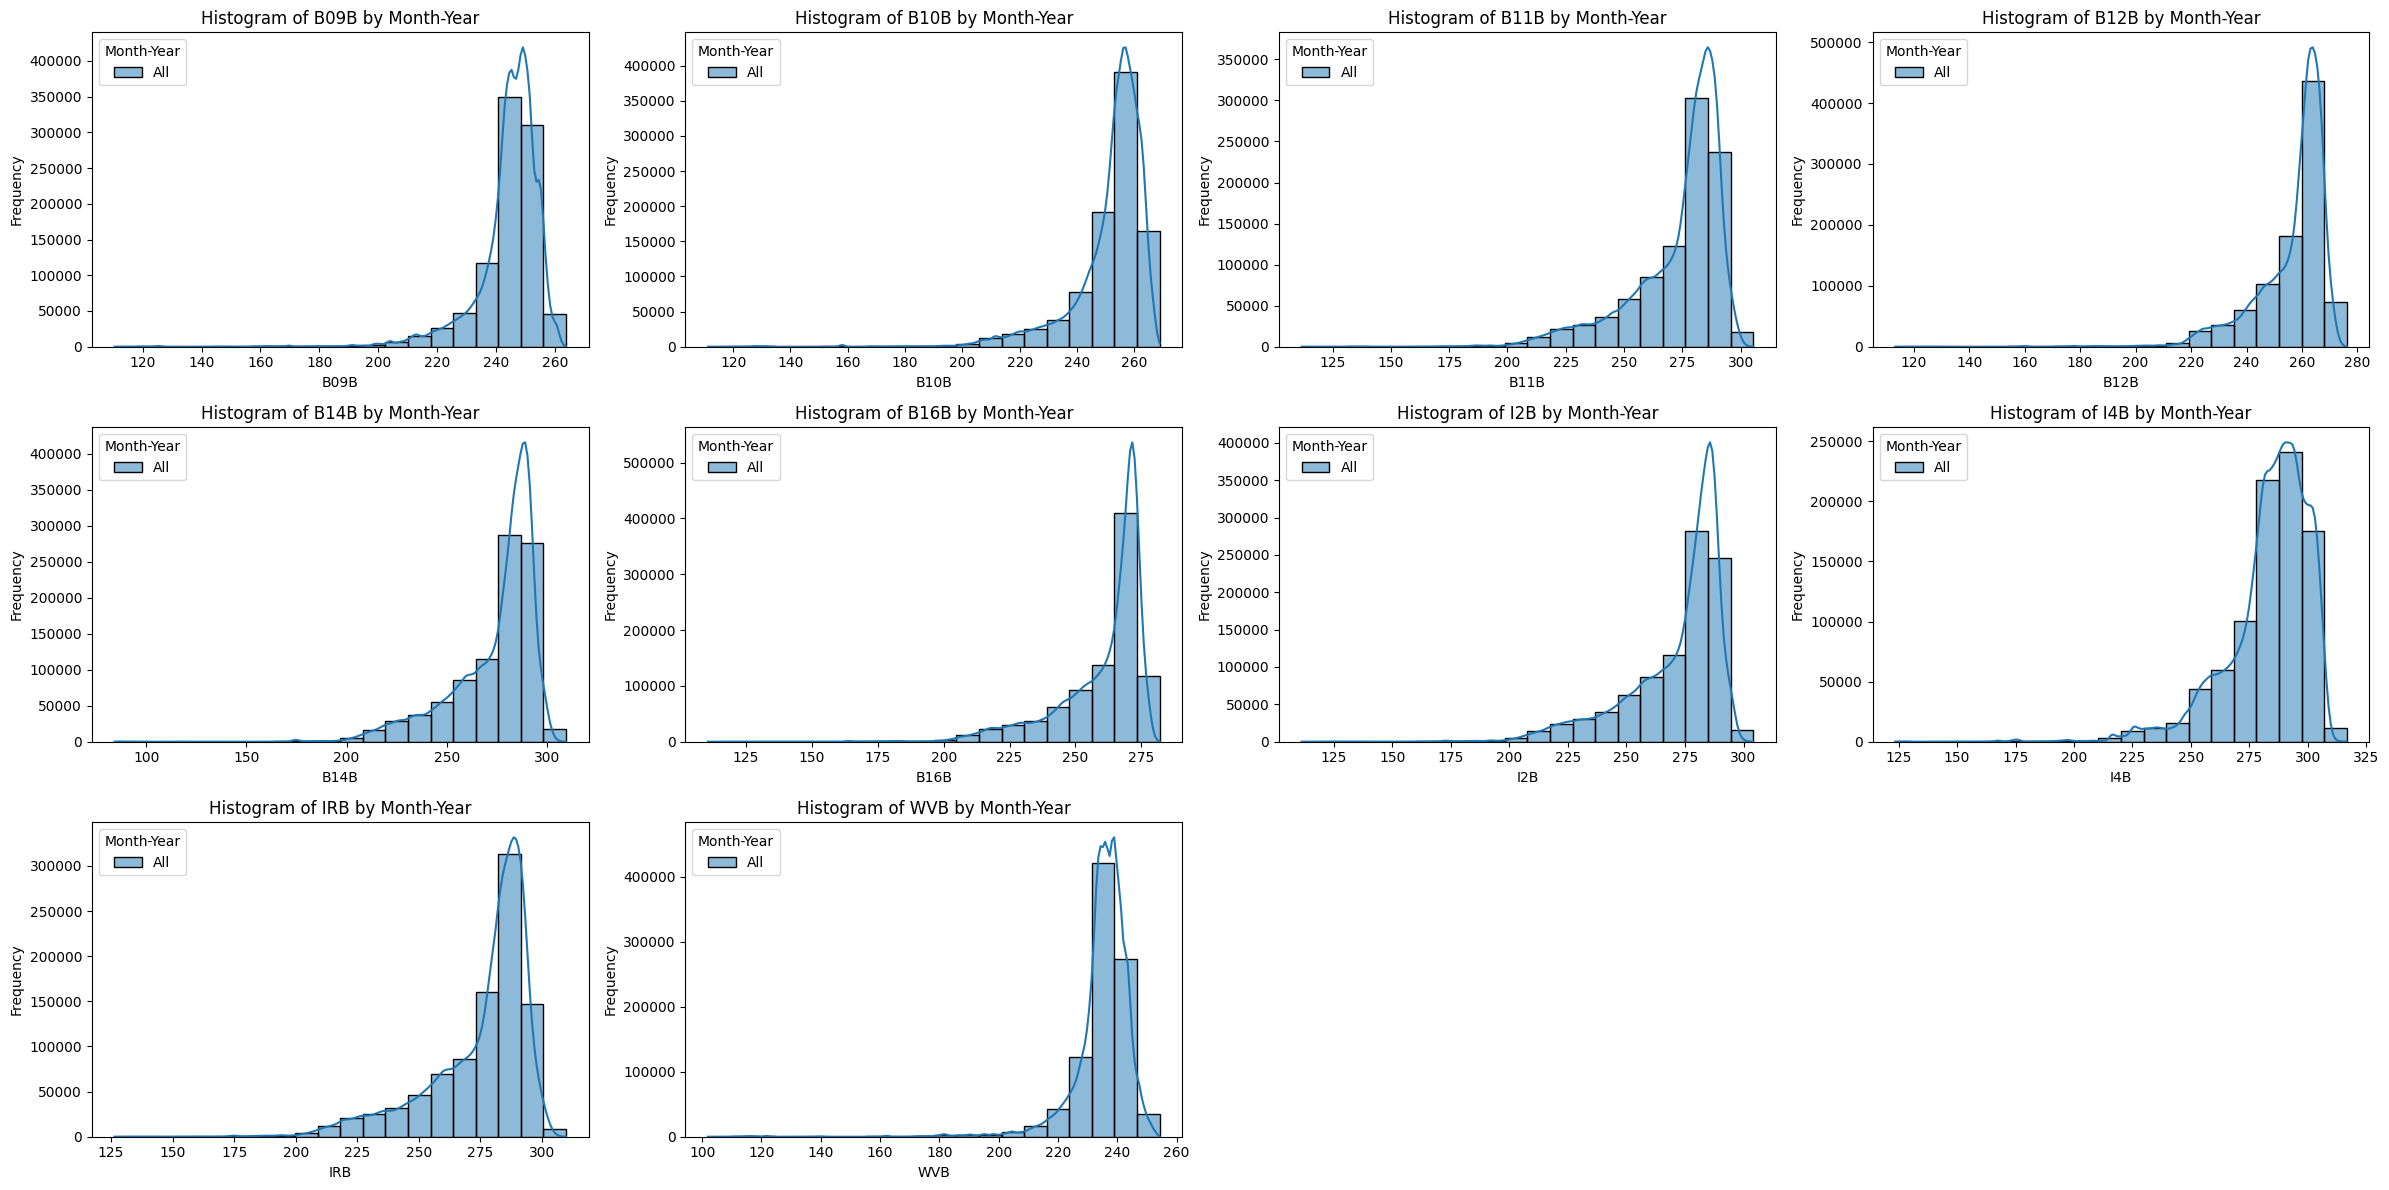

In [40]:
plot_histogram(dfs, features_hima)

Nhìn chung phân bố của các trường dữ liệu Hima giống nhau, đều có dạng  phân bố lệch trái nhẹ hoặc gần chuẩn, với đỉnh tập trung rõ ràng về phía bên phải (giá trị lớn hơn).

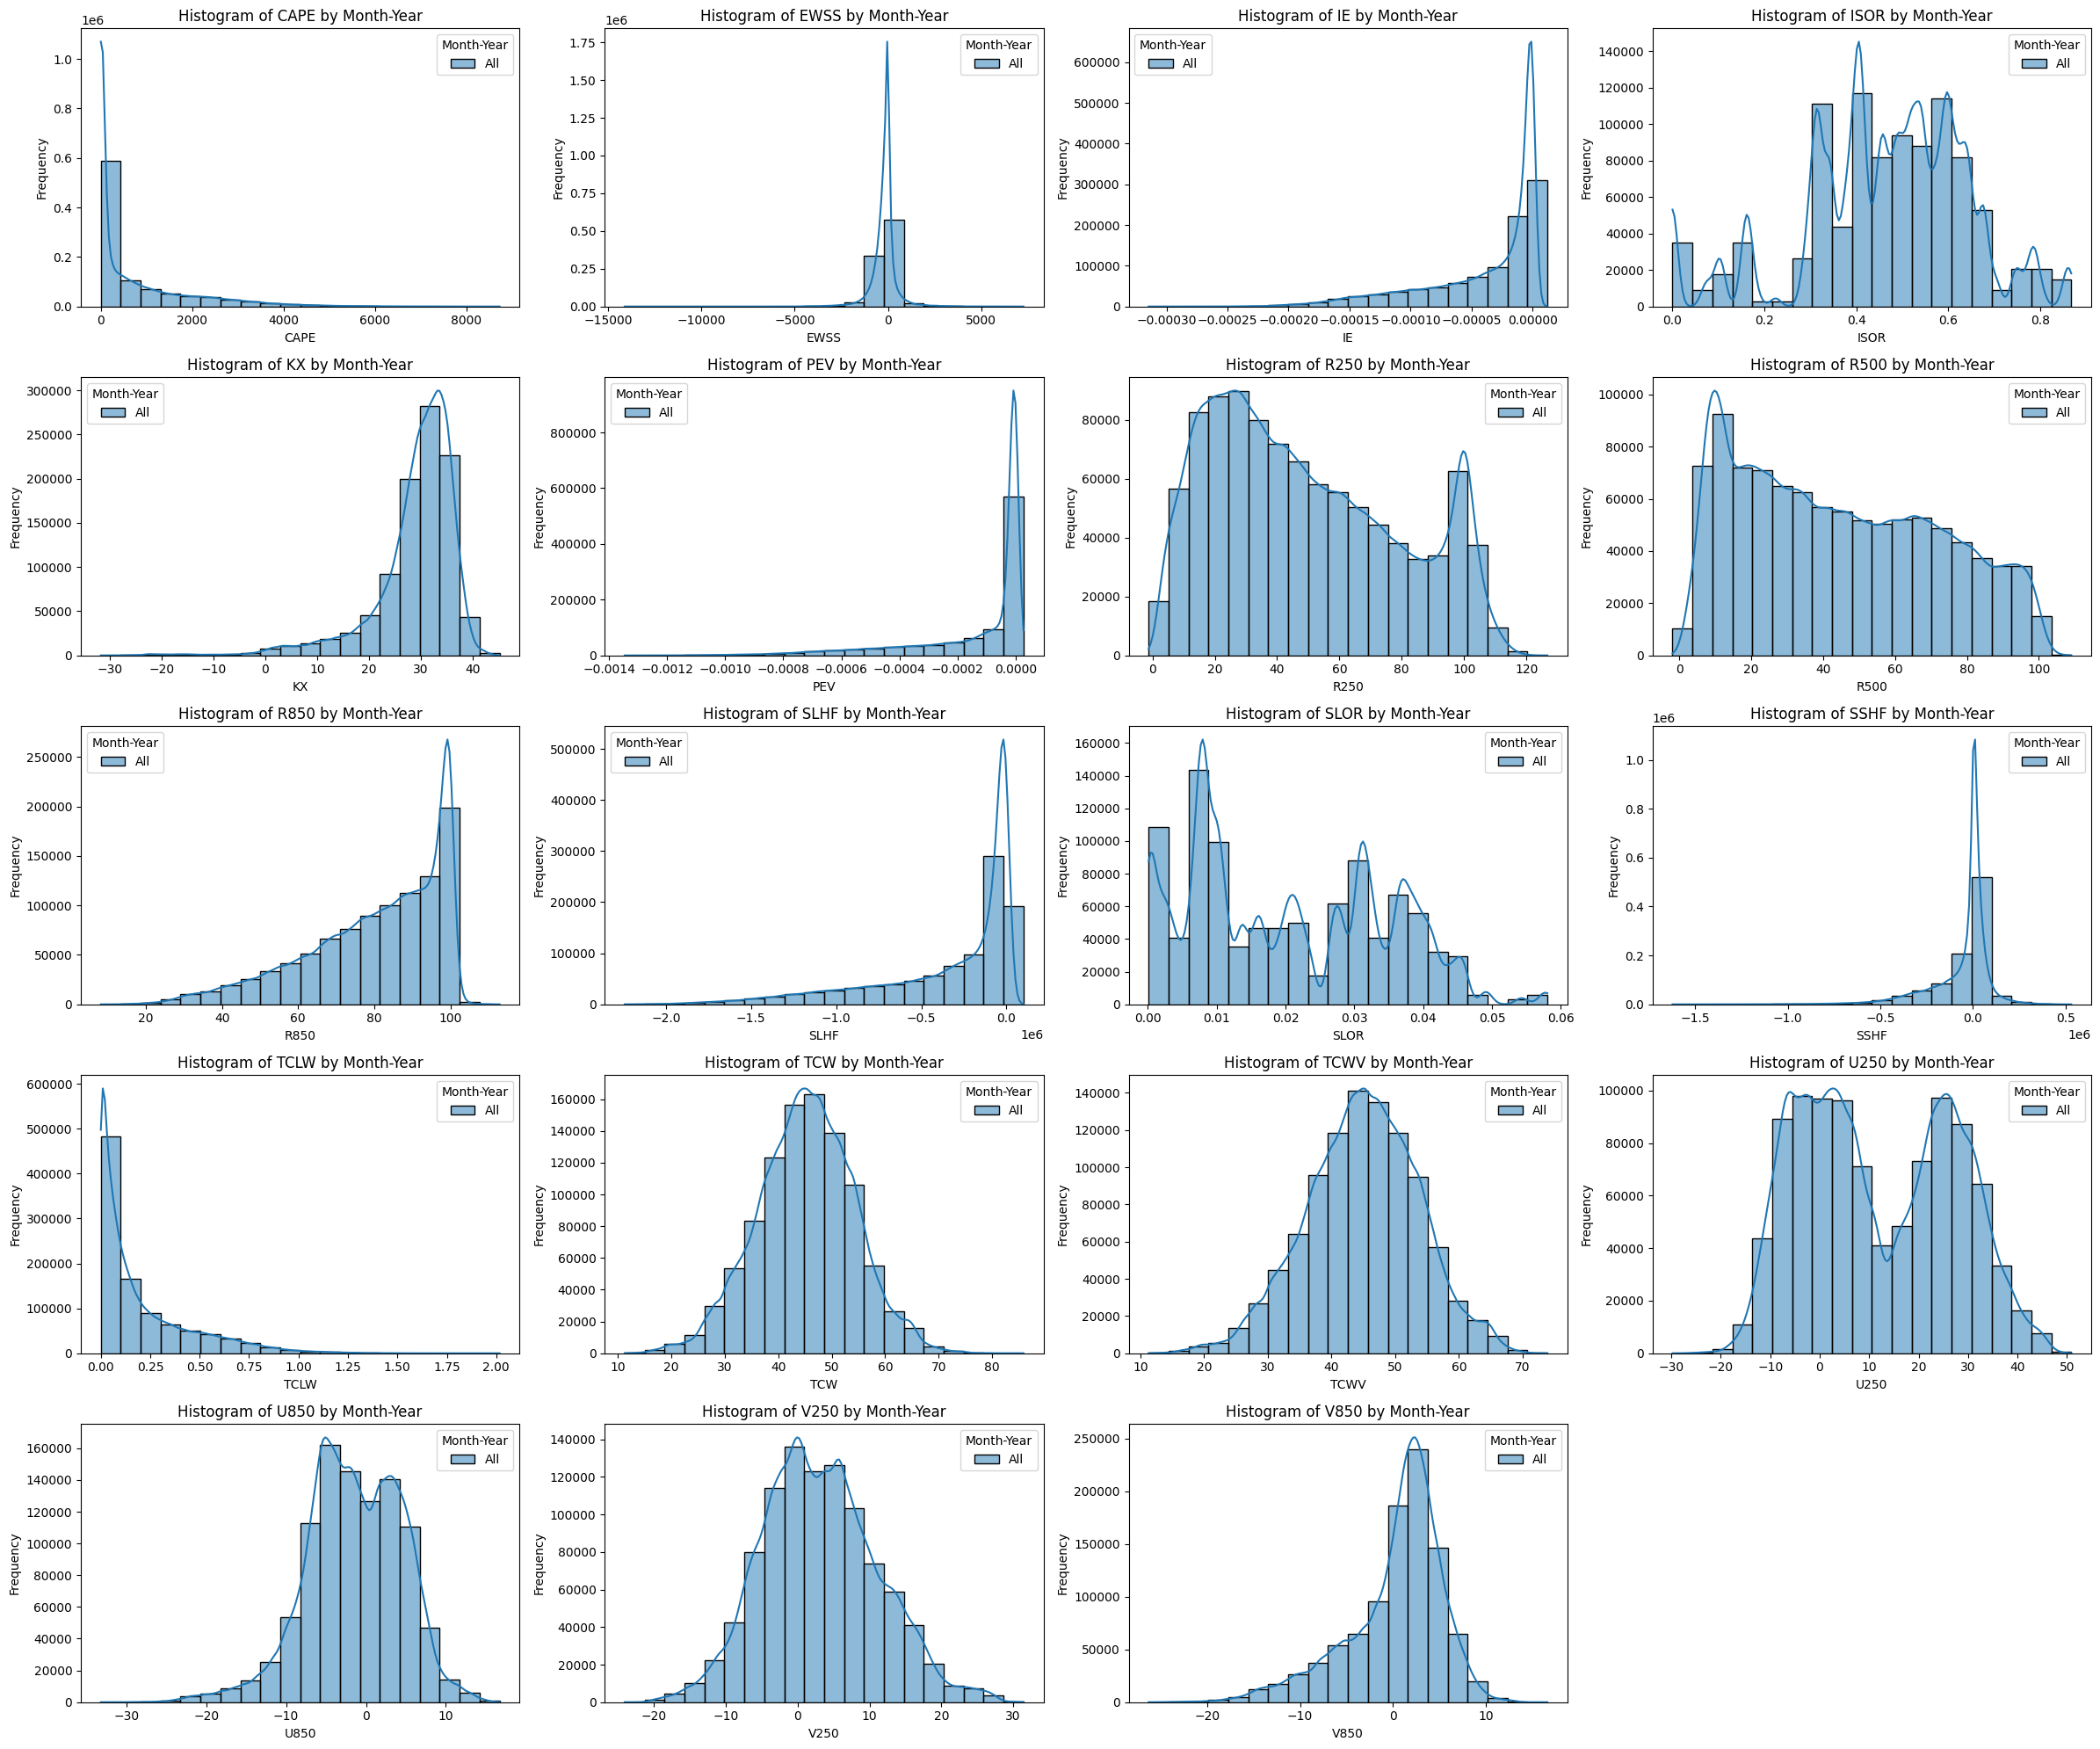

In [39]:
plot_histogram(dfs, features_era5)

Nhóm phân phối lệch/phân bố bất thường:
* CAPE, EWSS, IE, SLHF, SSHF: phân phối lệch phải rõ rệt, tập trung sát 0 và có đuôi kéo dài.
* SLOR, ISOR, SCAI: phân phối không chuẩn, nhiều đỉnh (multimodal) hoặc phân bố không đồng đều.
* R250, R500, R850: dạng lệch trái, nhiều giá trị nhỏ, ít giá trị lớn.

Nhóm phân phối gần chuẩn hoặc đối xứng:
* U250, V250, U850, V850: gần chuẩn, một số biến như U250 có xu hướng hai đỉnh.
* TCLW, TCWV: gần chuẩn rõ rệt, rất phù hợp cho các mô hình tuyến tính hoặc học sâu.
* KX, LFC, IE, PW: đa phần lệch phải nhưng dễ chuẩn hóa.

### **Đối với tập dữ liệu tháng 4 và 10**

In [35]:
dfs = {
    'April': df_april,
    'October': df_october
} 

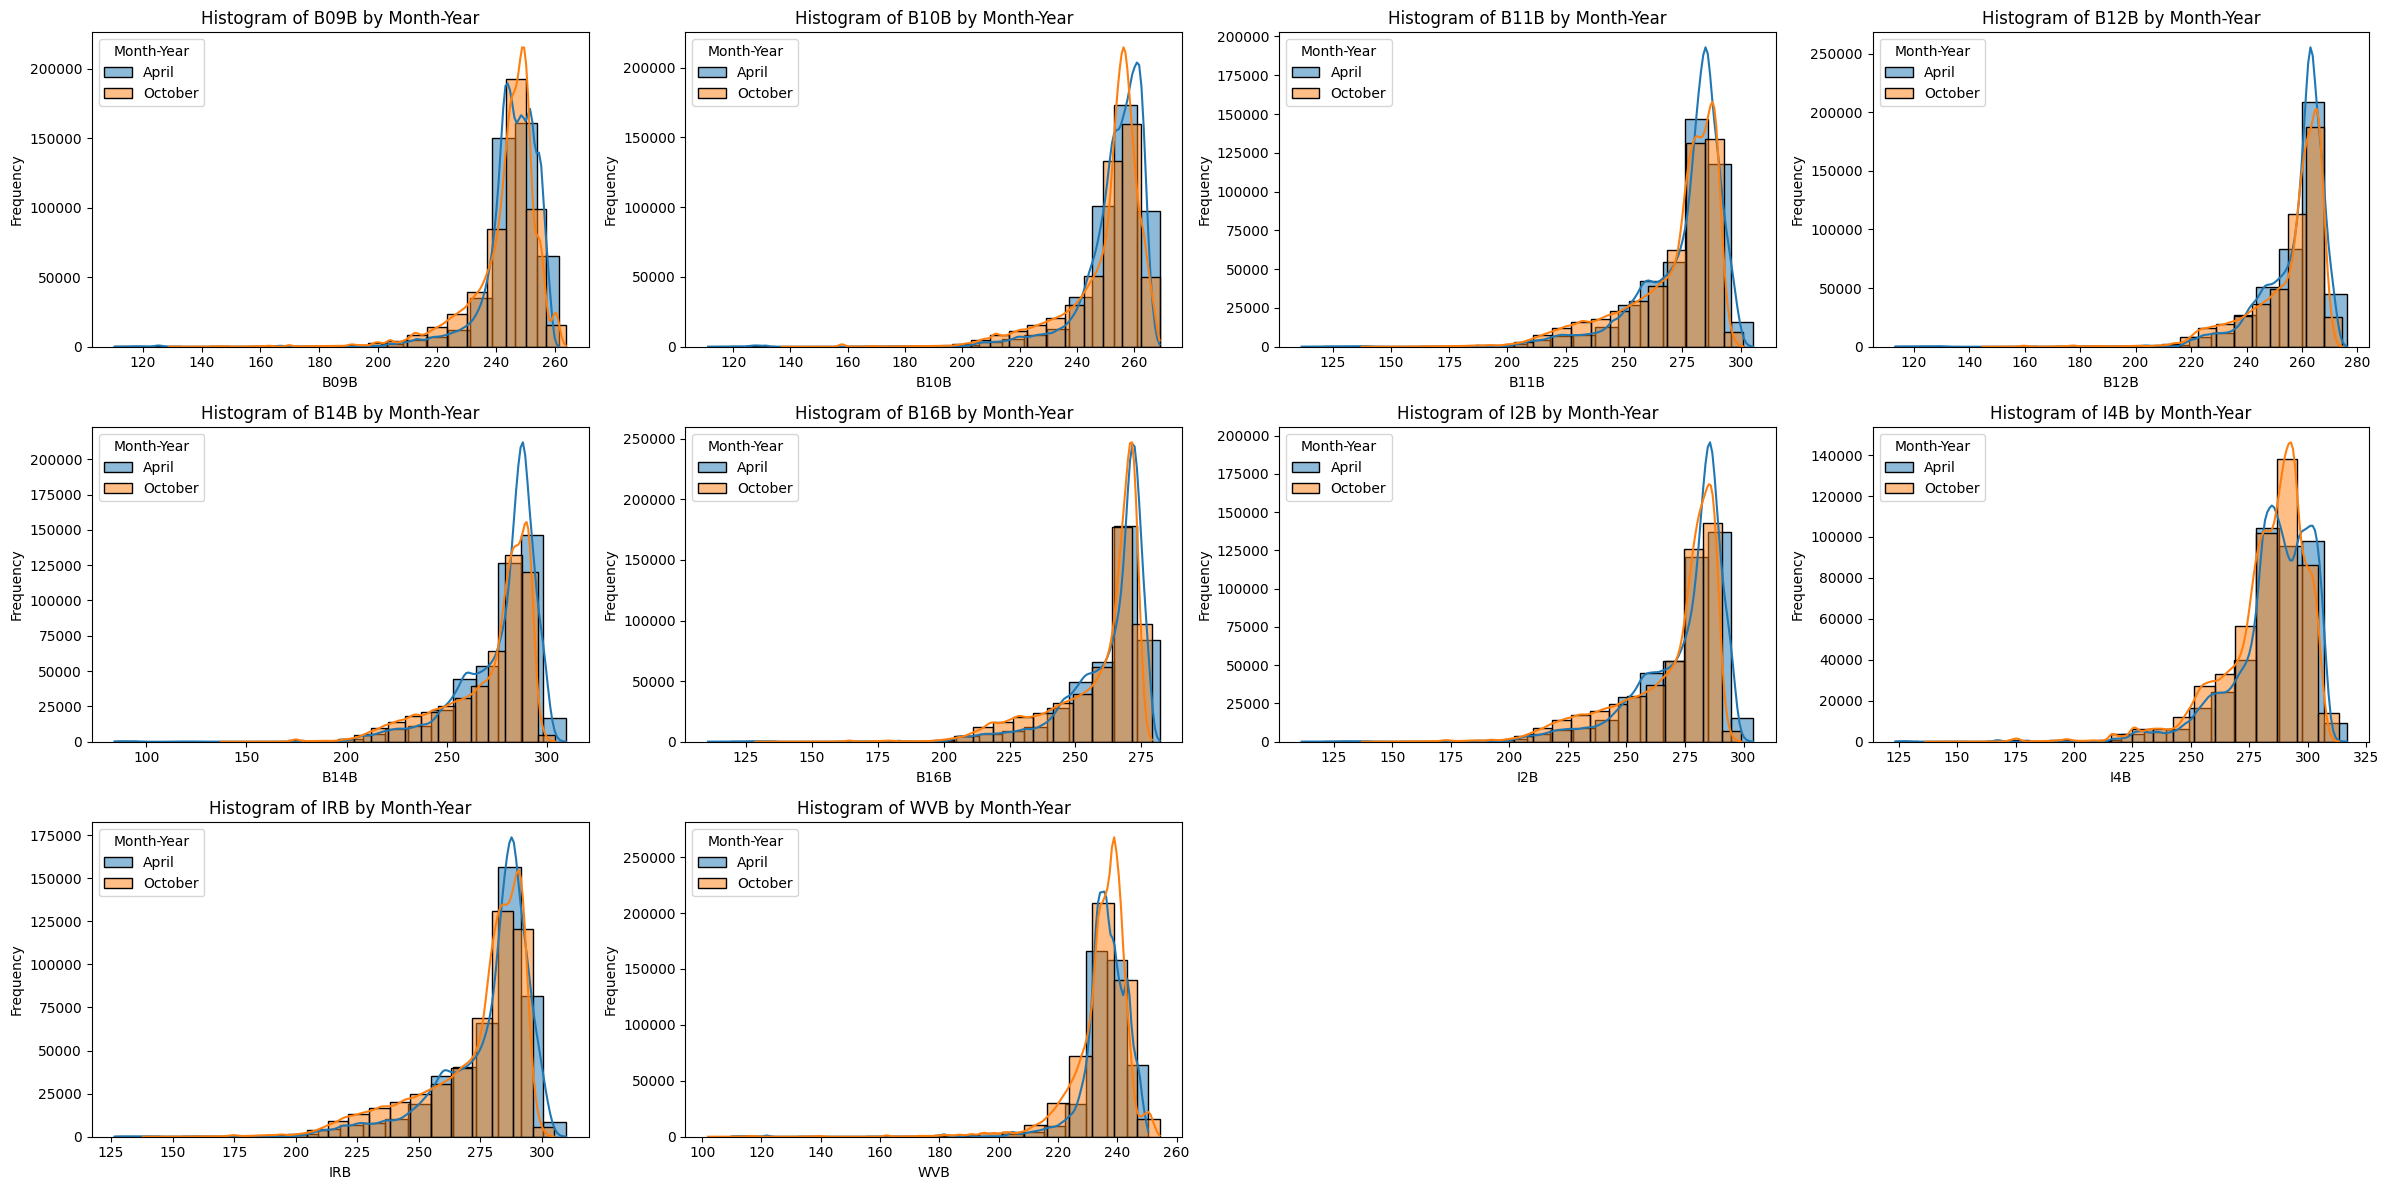

In [36]:
plot_histogram(dfs, features_hima)

Phân bố tương tự giữa tháng 4 và 10
* Các biến: B09B, B10B, B11B, B12B, B14B, B16B, I2B, I4B, IRB, WVB

=> Có dạng phân bố tương đối giống nhau giữa tháng 4 và 10, đỉnh lệch phải, tập trung giá trị cao.

Khác biệt nhẹ giữa tháng 4 và 10
* Một số biến như I2B, I4B, IRB có đỉnh phân bố hơi lệch nhẹ giữa 2 tháng, nhưng không đáng kể.
* Biến WVB cho thấy phân bố tháng 10 hẹp hơn một chút, có thể do ít outlier hơn hoặc khí hậu ổn định hơn.

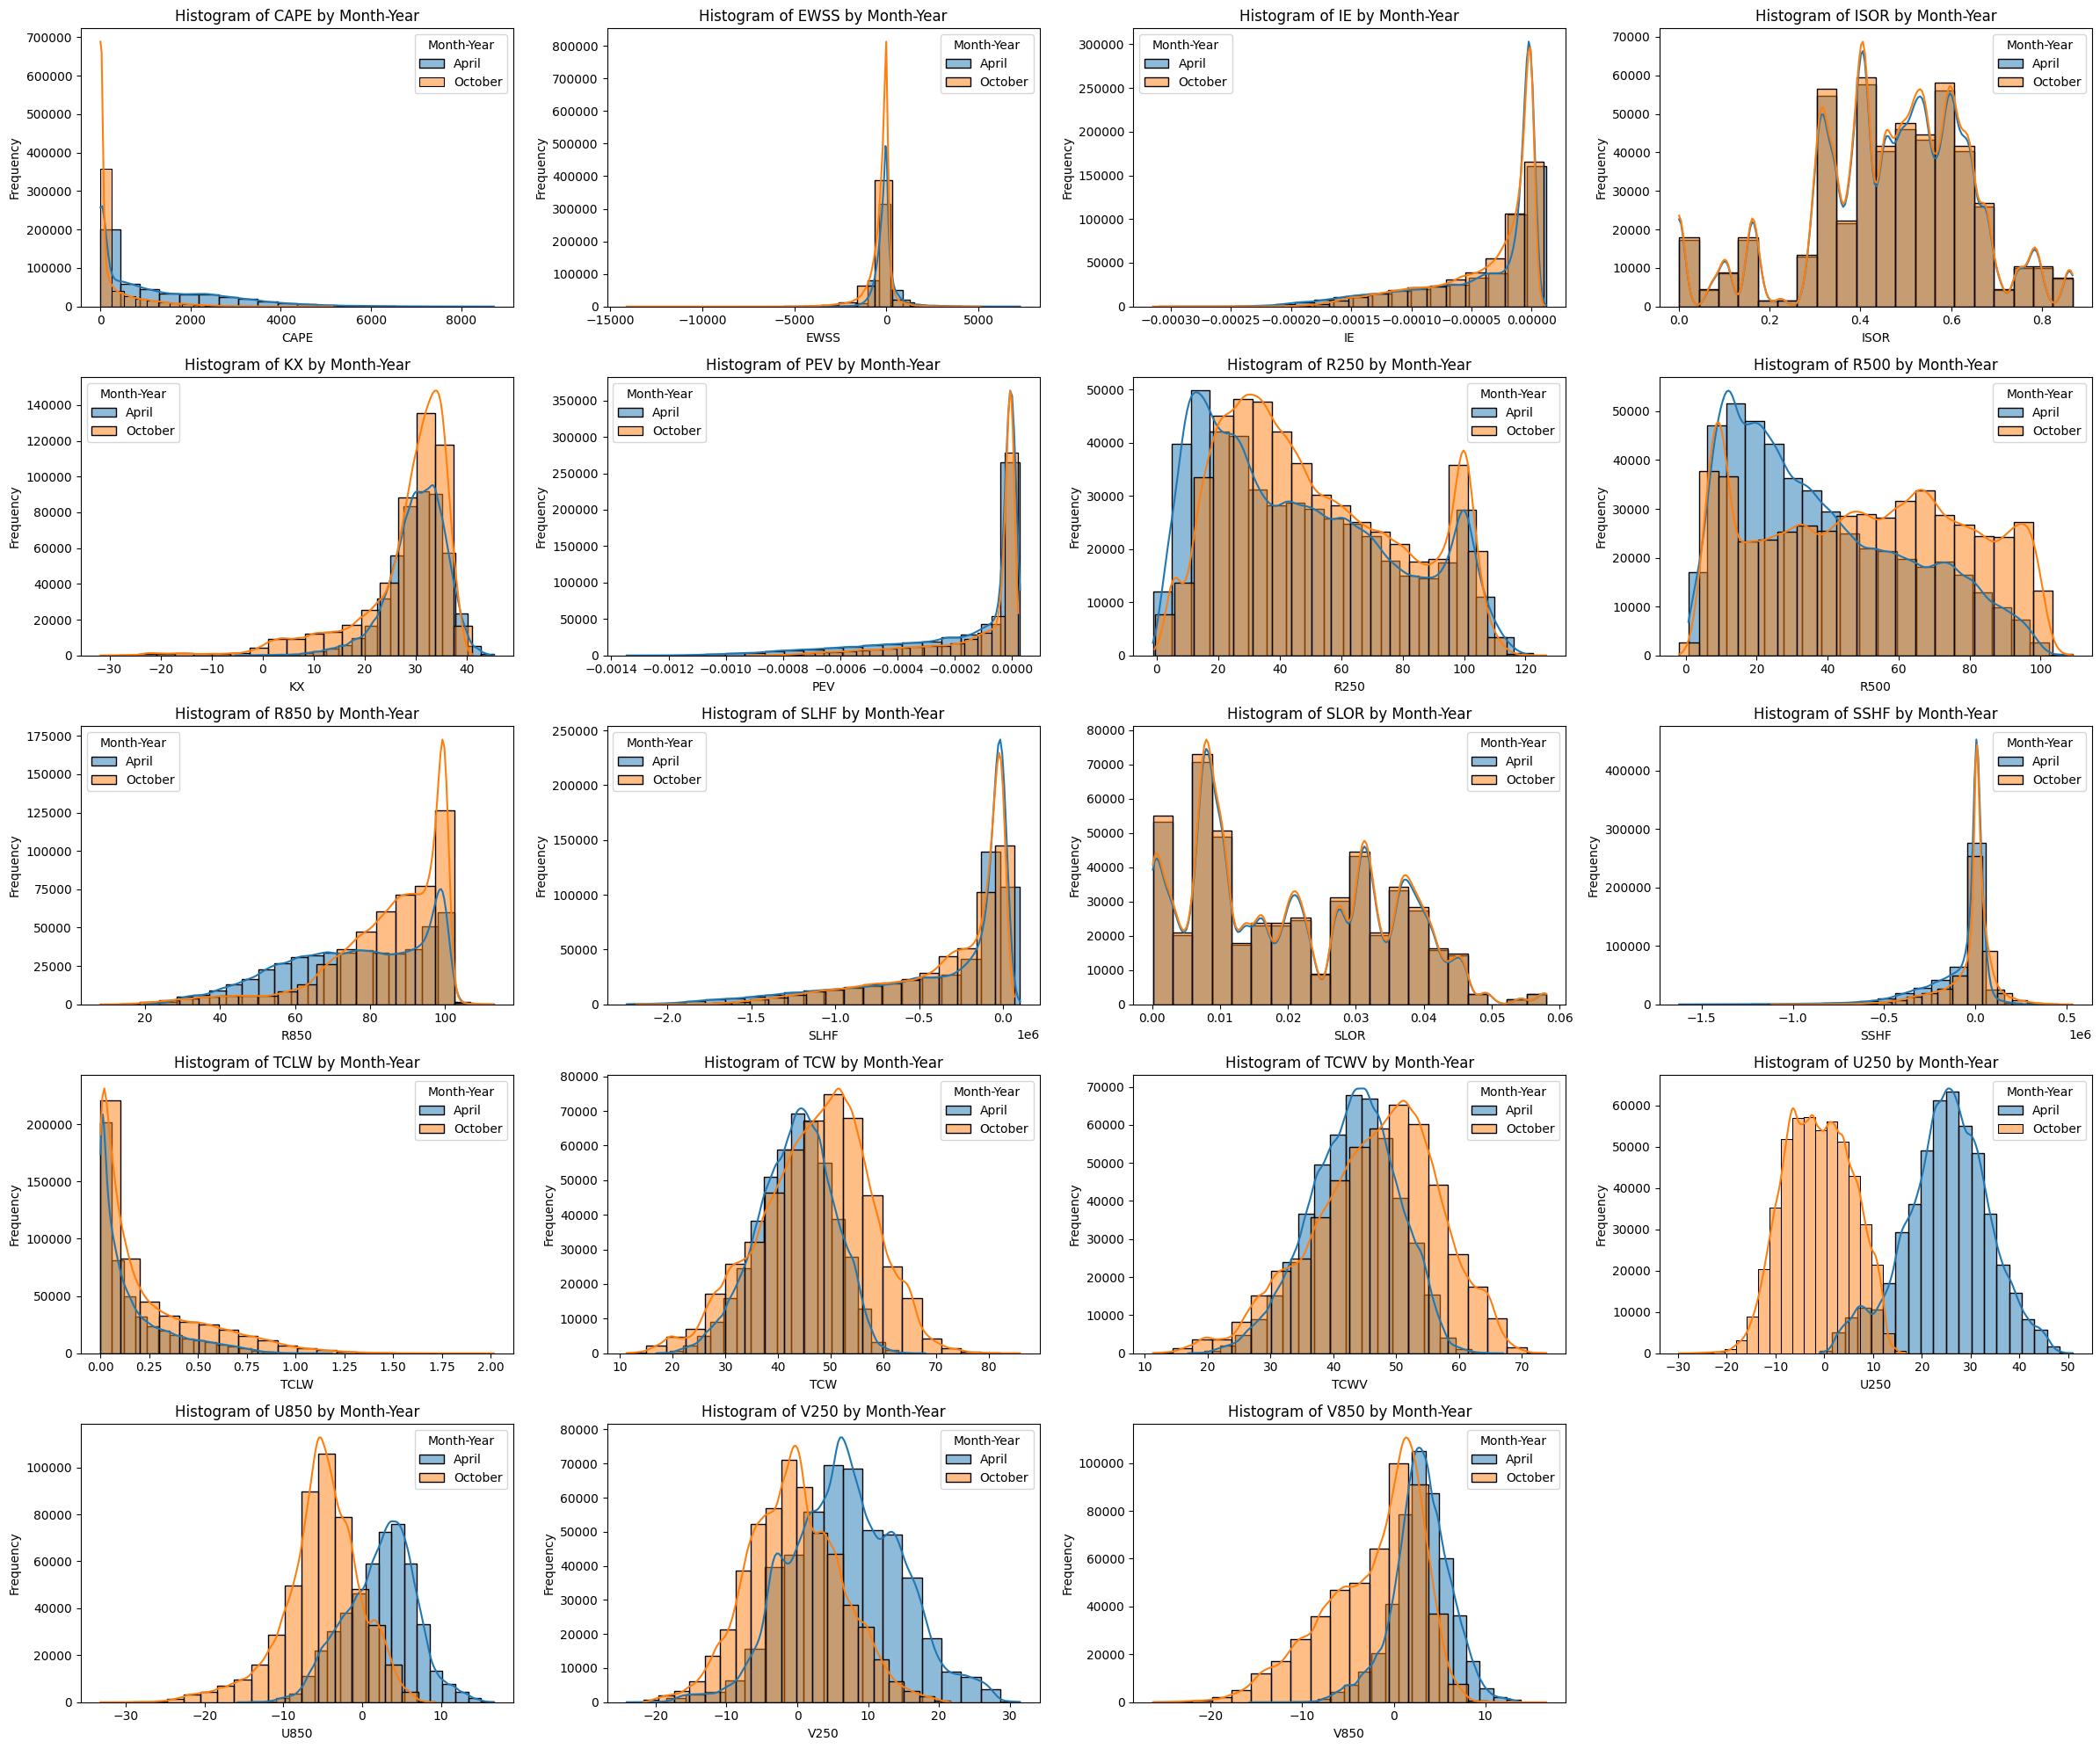

In [37]:
plot_histogram(dfs, features_era5)

Các biến có phân bố khác biệt rõ rệt giữa tháng 4 và 10
* CAPE, EVSS, SLHF, TCWV, U250, V250, V850, R850, Q850
=> Tháng 10 có xu hướng giá trị cao hơn hoặc phân bố rộng hơn, phản ánh đặc điểm mùa thu có nhiều đối lưu hơn/thay đổi khí quyển rõ rệt.

Các biến có phân bố gần giống nhau
* IE, EFY, Q500, SSTH, TCLW, TCCW, US50

=> Hai tháng có phân bố gần như trùng nhau, ít thay đổi theo mùa hoặc ảnh hưởng nhỏ.

Các biến có phân bố hơi lệch giữa hai tháng
* ISOR, R250, SLOR, SCAP, TCWV, V250

=> Phân bố tương đồng về dạng nhưng đỉnh lệch nhẹ, thường tháng 10 lệch phải.

## 4.4 Minh họa heat map

In [43]:
def plot_heatmap(df, title, cmap="Blues"):
    """
    Vẽ heatmap thể hiện ma trận tương quan giữa các đặc trưng trong DataFrame.
    """
    corr_matrix = df.corr().abs()  # Tính ma trận tương quan tuyệt đối

    plt.figure(figsize=(20, 15)) 
    sns.heatmap(corr_matrix, annot=True, cmap=cmap, fmt=".2f", linewidths=0.5)
    plt.title(f"Feature Correlation Map ({title})", fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

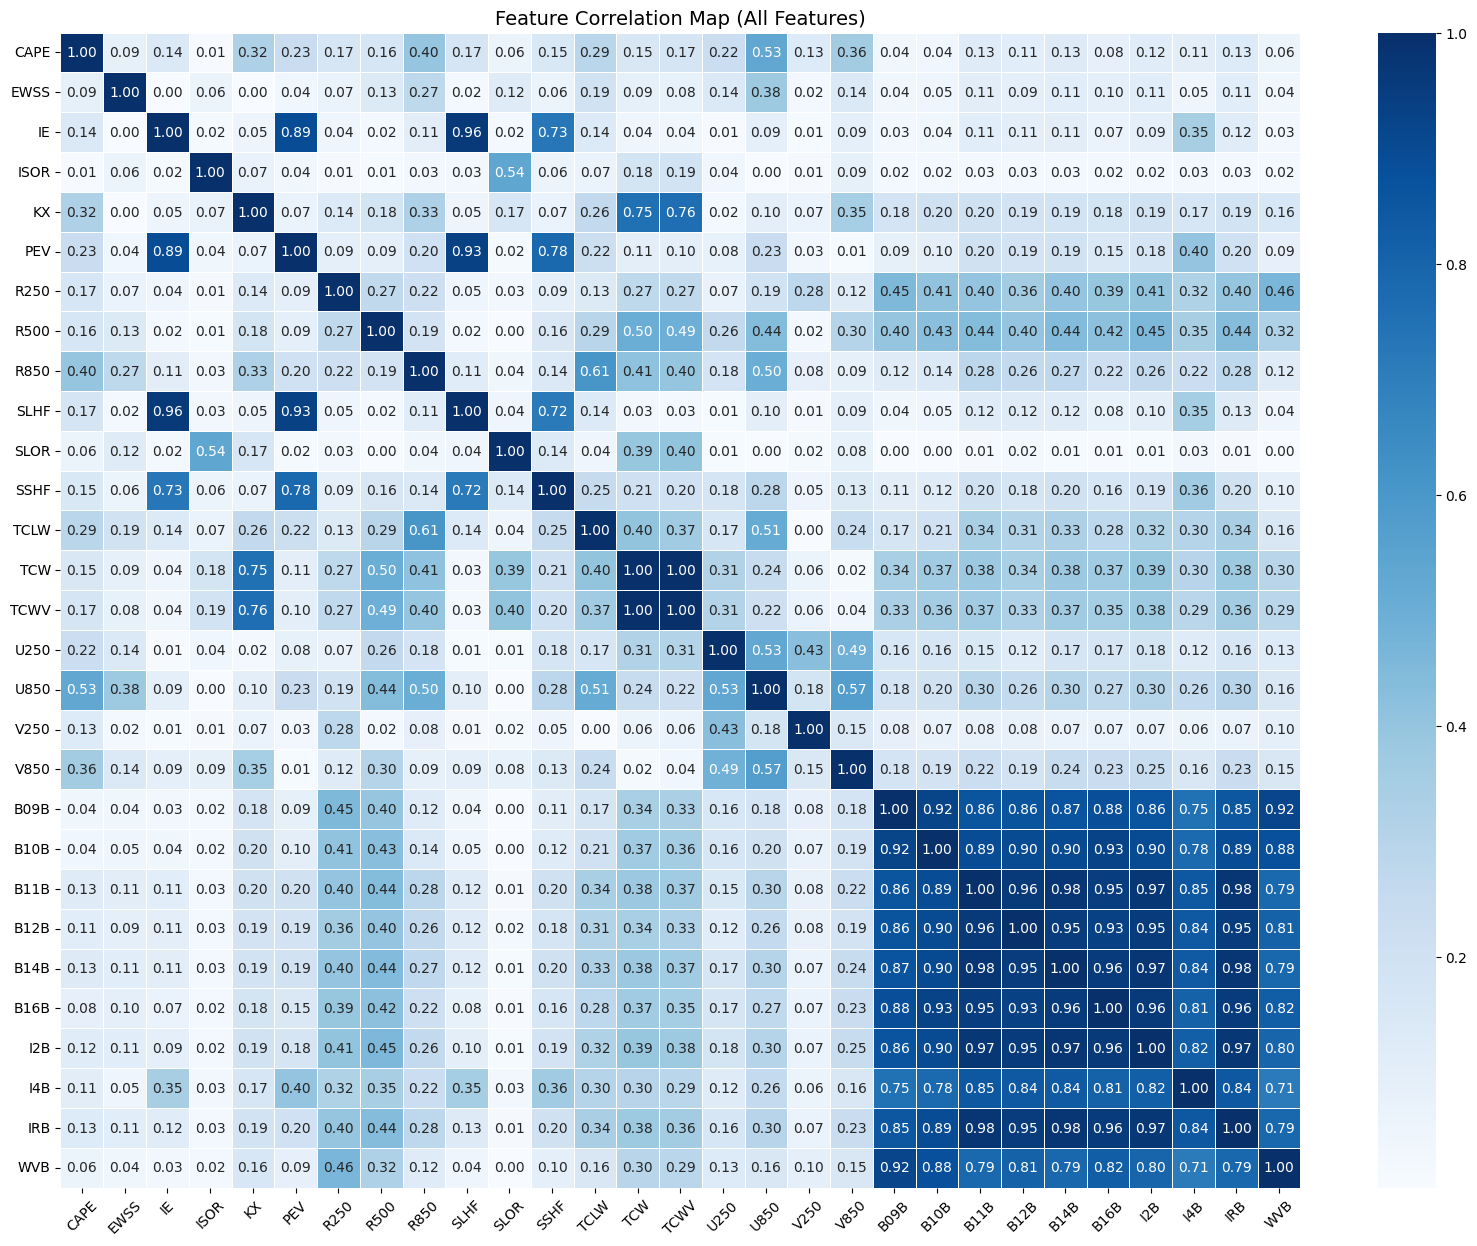

In [46]:
plot_heatmap(data[all_features], "All Features")

Nhóm kênh phổ vệ tinh (Band):
* Các biến như B09B, B10B, B11B, B12B, B14B, B16B, I2B, I4B, IRB, WVB có tương quan rất cao với nhau (từ 0.85–0.99) 

=> dư thừa thông tin

=> nên cân nhắc chọn một vài đại diện tiêu biểu.

Tập biến về hơi ẩm – mây – nước:
* TCW, TCWV, TCLW tương quan tốt với nhau (0.6–0.8), gợi ý về cùng hiện tượng vật lý  => có thể ảnh hưởng đến khả năng mưa.

Cặp biến động năng khí quyển:
* EWSS, IE, SLHF, SSHF, PEV… tương quan mạnh với nhau và có xu hướng liên kết với điều kiện mưa.

**Tương tự đối với dữ liệu tháng 4 và tháng 10**

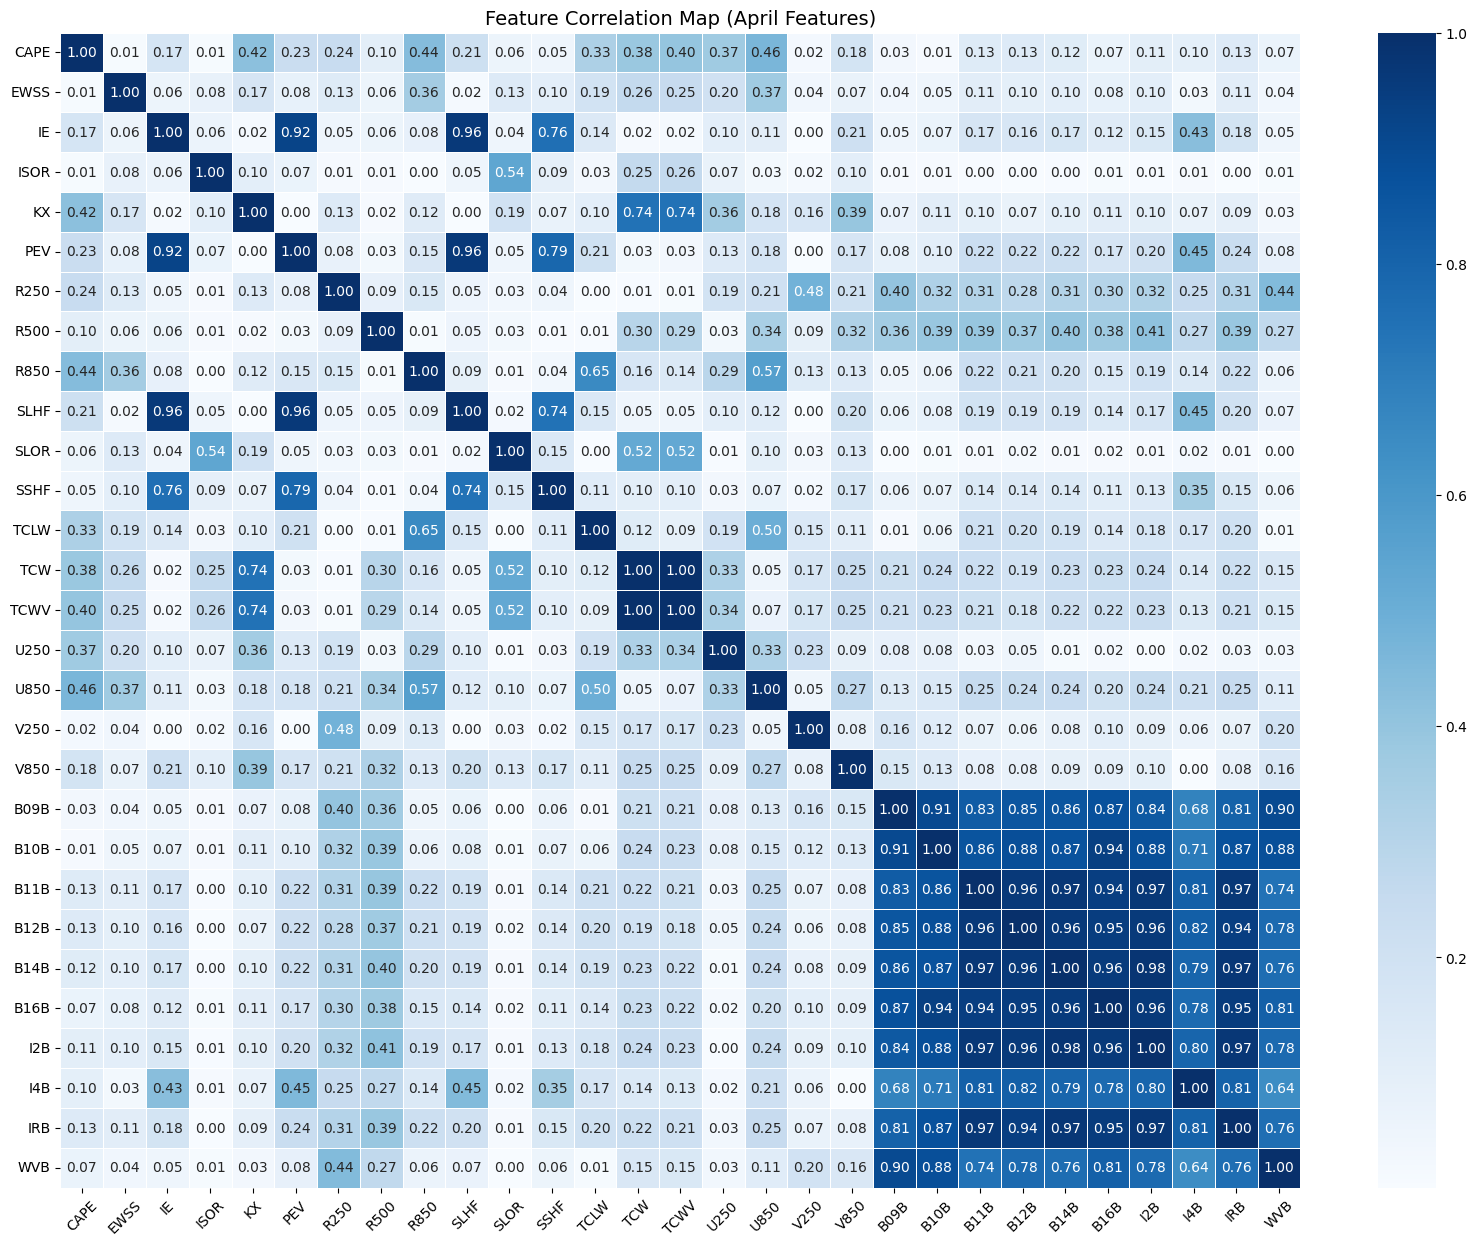

In [44]:
plot_heatmap(df_april[all_features], "April Features")

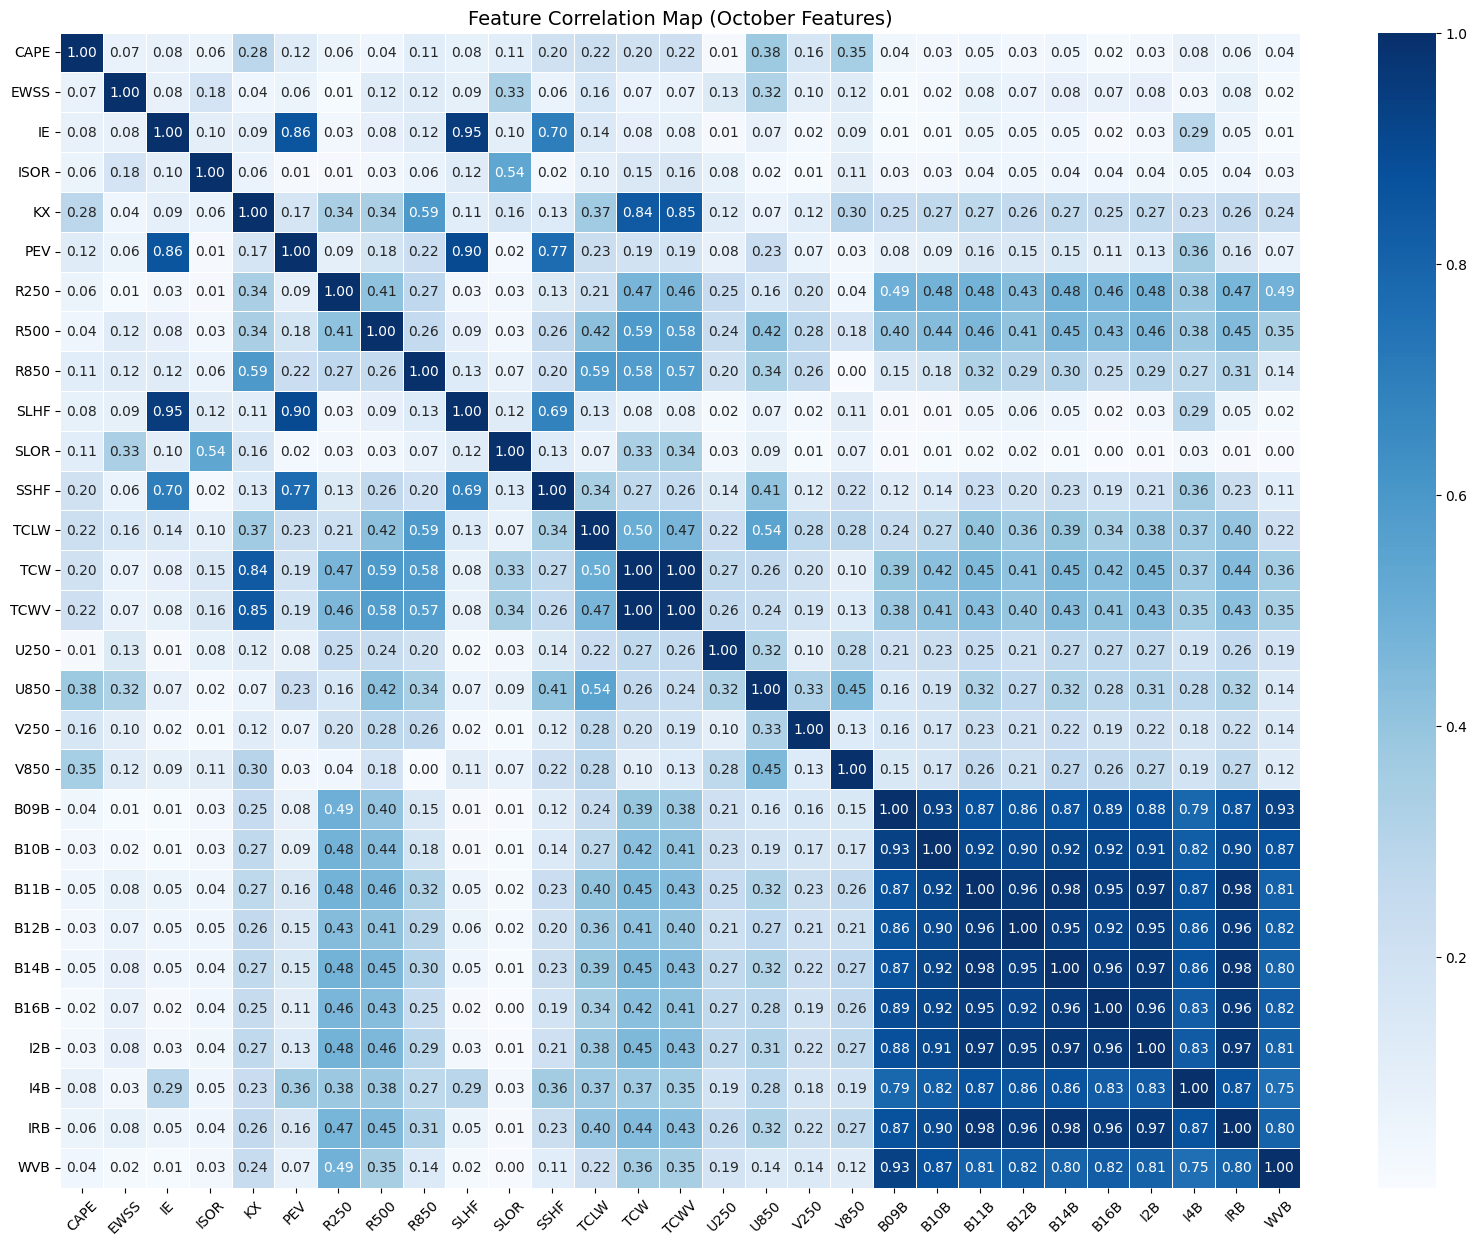

In [45]:
plot_heatmap(df_october[all_features], "October Features")

## 4.5 Tương quan với nhãn AWS

In [79]:
df_april_clean = df_april.drop(columns=['datetime', 'row', 'col'], errors='ignore')
df_october_clean = df_october.drop(columns=['datetime', 'row', 'col'], errors='ignore')
data_clean = data.drop(columns=['datetime', 'row', 'col', 'Rain_Label'], errors='ignore')

In [82]:
def plot_correlation_bar(df, title):
    correlation_with_aws = df.corr()["AWS"].drop("AWS")  # Bỏ tự tương quan

    plt.figure(figsize=(15, 8))
    sns.barplot(x=correlation_with_aws.index, y=correlation_with_aws.values, palette="coolwarm")
    plt.ylabel("Correlation with AWS")
    plt.xlabel("Features")
    plt.title(f" All Feature Correlation with AWS ({title})")
    plt.ylim(-0.35, 0.35)  # Giới hạn giá trị tương quan
    plt.axhline(0, color="black", linewidth=0.7, linestyle="--") 

    # Thêm giá trị trên mỗi cột
    for i in range(len(correlation_with_aws)):
        plt.text(i, correlation_with_aws.iloc[i], round(correlation_with_aws.iloc[i], 2), 
                 ha='center', va='bottom' if correlation_with_aws.iloc[i] > 0 else 'top')

    plt.xticks(rotation=45) 
    plt.show()

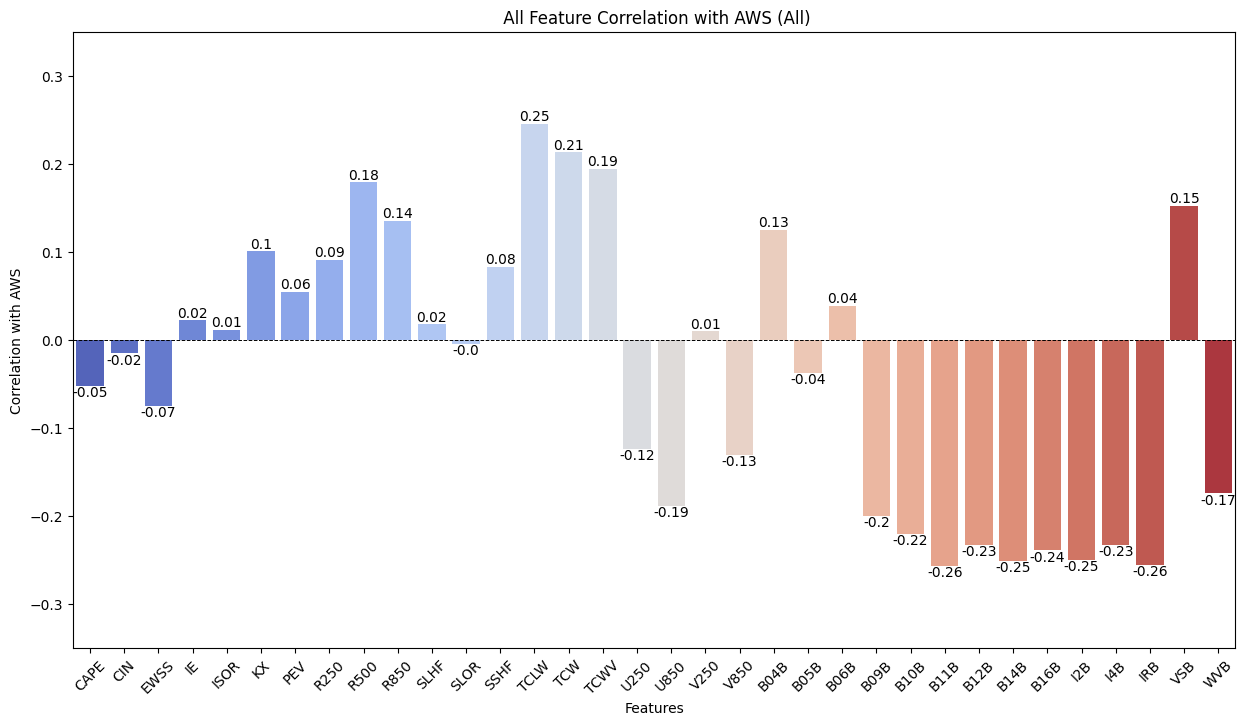

In [83]:
plot_correlation_bar(data_clean, "All")   

* TCWV, TCLW là đặc trưng liên quan mạnh nhất dương → đóng vai trò quan trọng.
* Các kênh HIMA như B06B, B11B, IRB, v.v. có tương quan âm mạnh → ảnh hưởng ngược chiều với AWS.
* WVB cũng âm khá rõ (-0.17), ngược lại I2B dương (0.15) → cùng là HIMA nhưng tác động khác nhau.

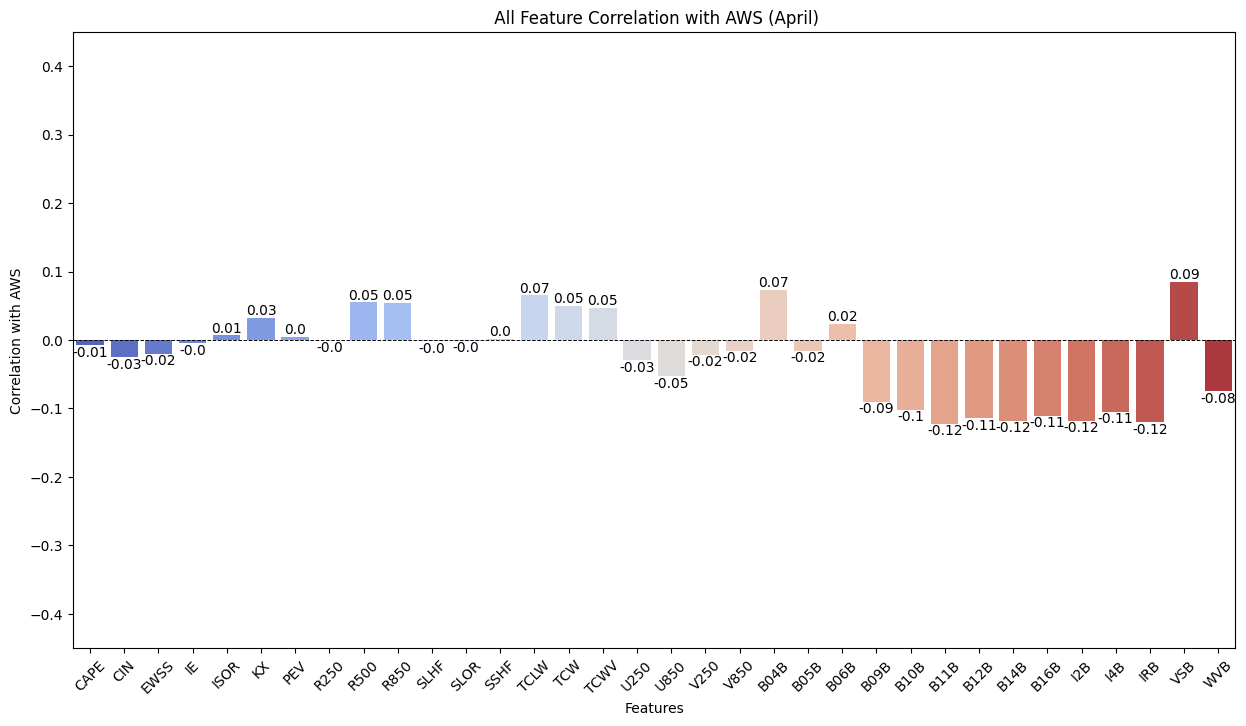

In [75]:
plot_correlation_bar(df_april_clean, "April")   

Nhìn chung, tháng 4 thì tất cả các đặc trưng đều có độ tương quan thấp với AWS, không có đặc trưng nào có mối liên hệ mạnh với lượng mưa AWS.

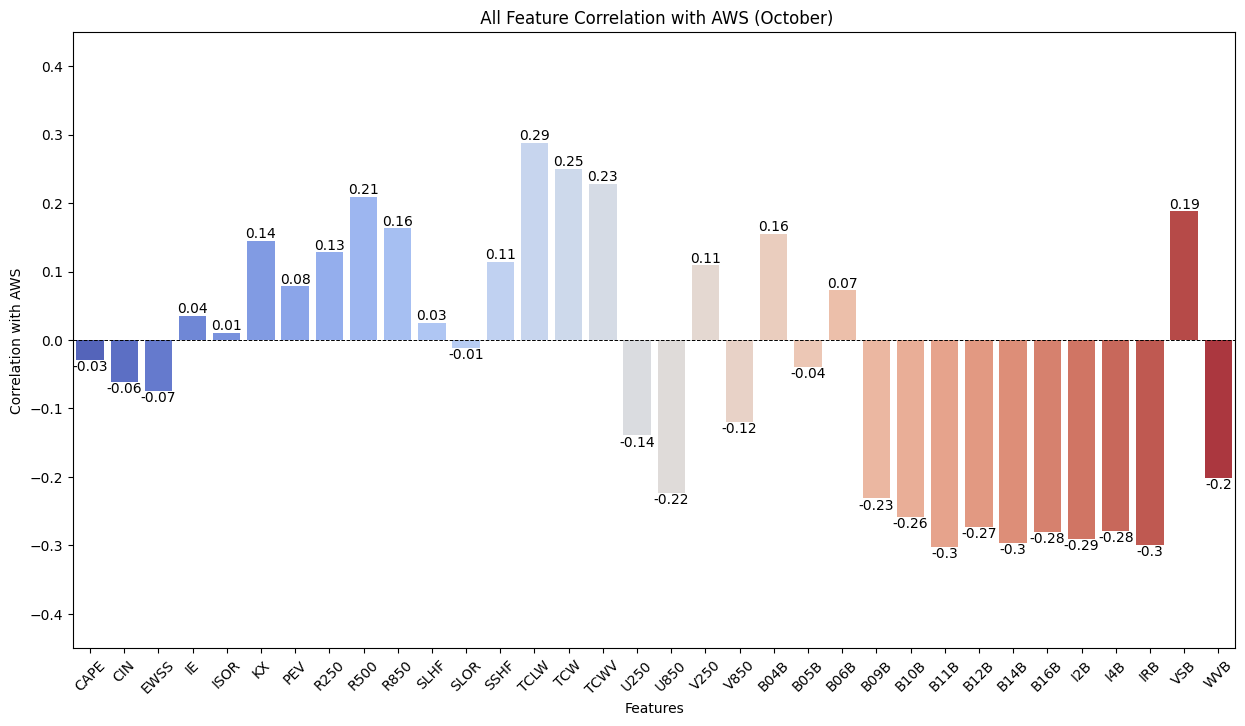

In [76]:
plot_correlation_bar(df_october_clean, "October")

* Các đặc trưng liên quan đến hơi nước trong khí quyển (TCLW, TCW, TCWV, R500) có quan hệ chặt với AWS.
* Các đặc trưng của Hima cũng có tương quan âm đáng kể
* Nhìn chung, TCWV, TCW, TCLW, R500, PEV, R250 là những yếu tố có liên hệ mạnh với mưa trong tháng 10.
* IE, ISOR, SLOR, SLHF, CAPE tương quan thấp

## 4.5 Phân bố nhãn AWS

Phân bố Rain_Label:
- No rain: 892195 (91.2%)
- Rain: 85757 (8.8%)


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


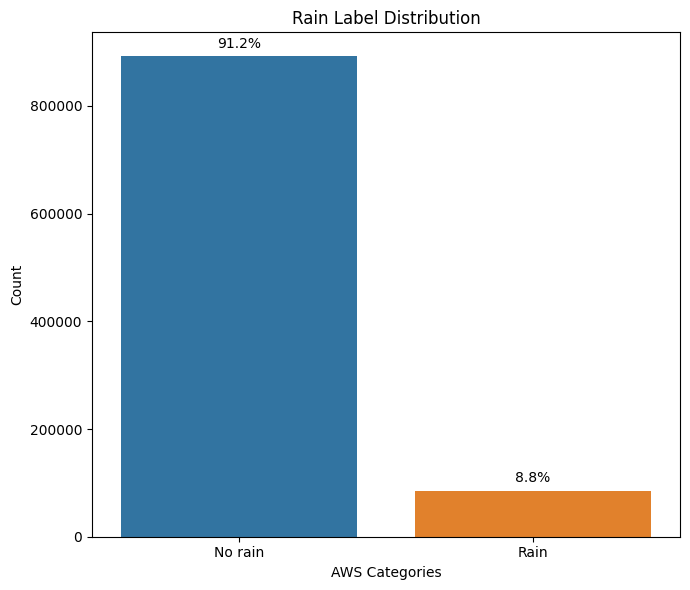

In [59]:
data['Rain_Label'] = (data['AWS'] > 0).astype(int)

# Đếm số lượng từng nhãn
label_counts = data['Rain_Label'].value_counts().sort_index() 
labels = ['No rain', 'Rain']
counts = [label_counts[0], label_counts[1]]
total = sum(counts)
percentages = [f'{(c / total * 100):.1f}%' for c in counts]

# In ra số lượng và phần trăm
print("Phân bố Rain_Label:")
for label, count, pct in zip(labels, counts, percentages):
    print(f"- {label}: {count} ({pct})")

# Vẽ biểu đồ
plt.figure(figsize=(7, 6))
ax = sns.barplot(x=labels, y=counts)

# Ghi phần trăm trên từng cột
for i, (count, pct) in enumerate(zip(counts, percentages)):
    ax.text(i, count + total * 0.01, pct, ha='center', va='bottom', fontsize=10)

plt.title('Rain Label Distribution')
plt.ylabel('Count')
# plt.xlabel('Label')
plt.xlabel("AWS Categories")
plt.tight_layout()
plt.show()

In [55]:
def plot_aws_stats(df, month, ax):
    # Thống kê các giá trị AWS = 0, AWS < 0, AWS > 0,
    aws_stats = {
        'No rain': len(df[df['AWS'] == 0]),
        'Rain': len(df[df['AWS'] > 0]),
    }
    
    aws_percent = {key: (value / len(df)) * 100 for key, value in aws_stats.items()}
    
    # Tạo DataFrame thống kê
    stats_df = pd.DataFrame({
        'Count': aws_stats,
        'Percent (%)': aws_percent
    }).sort_values(by='Count', ascending=False)
    
    # Vẽ biểu đồ Count
    sns.barplot(x=stats_df.index, y=stats_df['Count'], ax=ax)
    ax.set_title(f"Count of AWS Values ({month})")
    ax.set_xlabel("AWS Categories")
    ax.set_ylabel("Count")
    
    for i, (count, percent) in enumerate(zip(stats_df['Count'], stats_df['Percent (%)'])):
        ax.text(i, count + 10, f"{percent:.2f}%", ha='center', va='bottom', fontsize=10)
    
    print(f"Statistics for {month}:")
    print(stats_df)
    print("\n")

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Statistics for April:
          Count  Percent (%)
No rain  282518    58.740436
Rain      23328     4.850299


Statistics for October:
          Count  Percent (%)
No rain  289406    58.231521
Rain      62429    12.561369




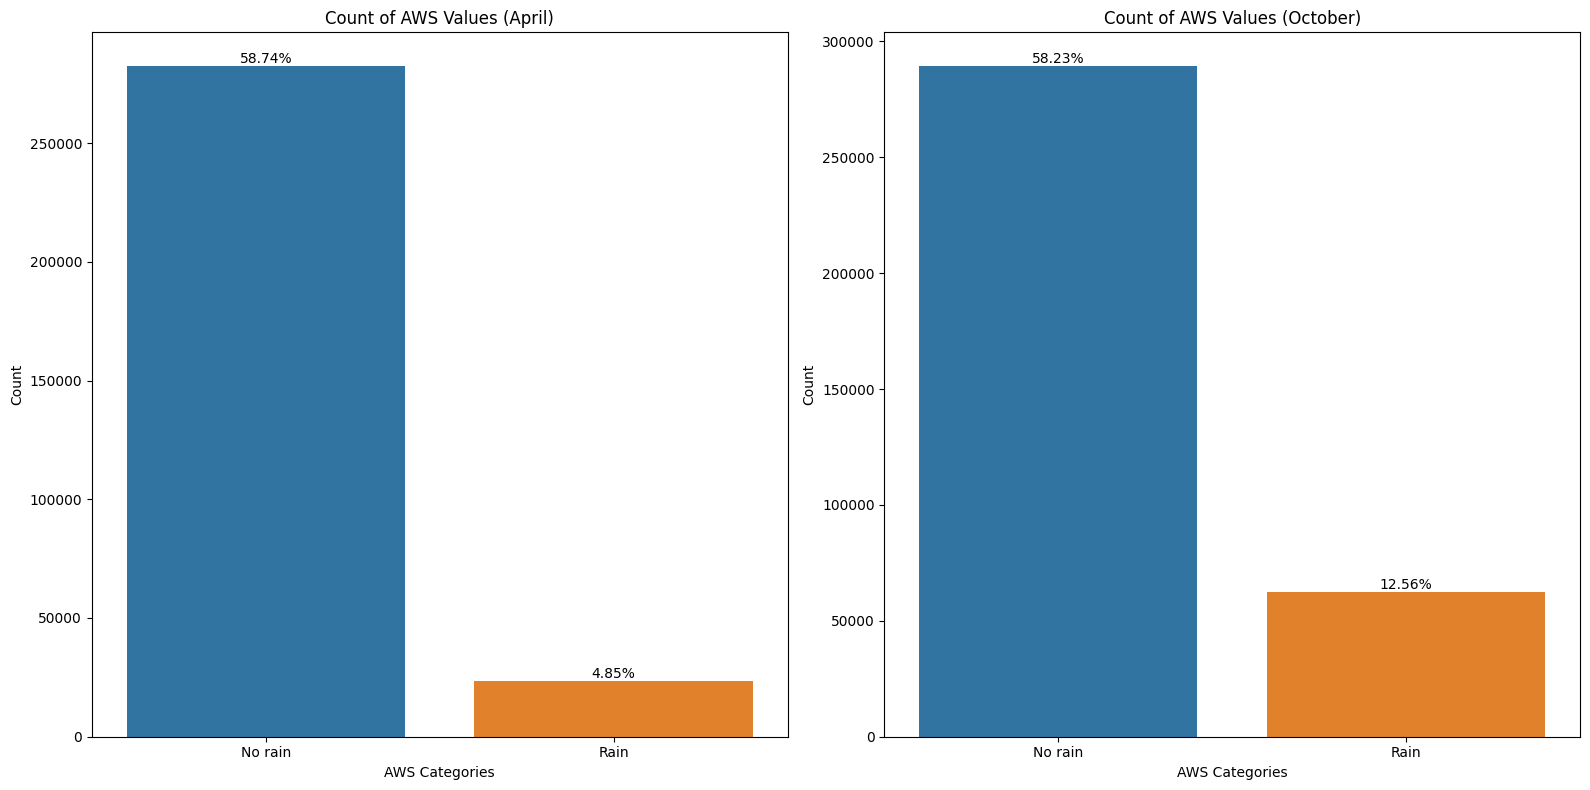

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for month, df, ax in zip(["April", "October"], [df_april, df_october], axes):
    plot_aws_stats(df, month, ax)

plt.tight_layout()
plt.show()

Phân bố nhãn không đều ở tất cả các bộ dữ liệu.
* Bộ dữ liệu chung: tỷ lệ giữa nhãn không mưa là 91.2% trong khi tỷ lệ nhãn mưa quá thấp vào khoảng 8.8%. Nếu xử lý outlier có thể làm mất dữ liệu có nhãn mưa.
* Bộ dữ liệu tháng 4 và 10: tương tự với bộ dữ liệu chung, tỷ lệ mất cân bằng giữa 2 nhãn là rất cao tuy nhiên nhãn mưa của tháng 10 nhỉnh hơn một chút cho thấy tháng 10 mưa nhiều hơn so với tháng 4.